In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('whitegrid')
palette = sns.color_palette('coolwarm')
sns.set_palette(palette)
basic_color = palette[0]
highlt_color = palette[5]

%run viz_functions.py
import viz_functions

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('client-segmentation/data/online_shoppers_intention.csv')
df.head()

Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb                 2   
2         0.20       0.20         0.0         0.0   Feb                 4   
3         0.05       0.14         0.0         0.0   Feb                 3   
4         0.02       0.05         0.0         0.0   Feb                 3   

   Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
0        1       1            1  Returning_Visitor    False    False  
1        2       1            2  Returning_Visitor    False    False  
2        1       9            3  Returning_Visitor    False    False  
3        2       2            4  Returning_Visitor    False    False  
4        3       1            4  Returning_Visitor     True    False

In [3]:
df.shape

(12330, 18)

# 1. Описание данных

В датасете есть 18 переменных: 10 числовых и 8 категориальных. Разделим их.<br><br>
**Числовые**:
- Administrative - кол-во страниц этого типа (Administrative), которые посетил пользователь 
- Administrative_Duration - кол-во времени, которое он провел на страницах этого типа
- Informational - кол-во страниц этого типа (Informational), которые посетил пользователь
- Informational_Duration - кол-во времени, которое он провел на страницах этого типа
- ProductRelated - кол-во страниц этого типа (ProductRelated), которые посетил пользователь
- ProductRelated_Duration	- кол-во времени, которое он провел на страницах этого типа
- BounceRates	- процент посетителей, которые заходят на сайт через эту страницу и ухдят без дополнительных действий
- ExitRates - процент просмотров страницы сайта, которые заканчивают на этой конкретной странице
- PageValues - средняя ценность веб-страницы, которую пользователь посетил до завершения транзакции
- SpecialDay - указывает близость времени посещения к праздничному дню (Дню св. Валентина и тп), когда сеансы с большей вероятностью завершатся транзакцией


**Категориальные**:
- Month	- месяц просмотра
- OperatingSystems - операционная система устройства просмотра
- Browser - браузер просмотра
- Region - регион просмотра
- TrafficType - тип трафика, в который попал пользователь
- VisitorType - тип пользлователя
- Weekend - маркер на выходной день
- Revenue - маркер на то, совершил ли пользователь покупку 

In [4]:
numeric = ['Administrative', 'Administrative_Duration', 'Informational',
           'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
           'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

categ = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 
         'VisitorType', 'Weekend', 'Revenue']

# 2. Exploratory Data Analysis

In [5]:
# data types
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

## 2.1. Пропуски и нулевые значения

In [6]:
def nans(df):
    nans = pd.DataFrame({'Количество пропусков' : df.isna().sum()})
    return nans

In [7]:
# числовые
nans(df[numeric])

Количество пропусков
Administrative                              0
Administrative_Duration                     0
Informational                               0
Informational_Duration                      0
ProductRelated                              0
ProductRelated_Duration                     0
BounceRates                                 0
ExitRates                                   0
PageValues                                  0
SpecialDay                                  0

In [8]:
# категориальные
nans(df[categ])

Количество пропусков
Month                                0
OperatingSystems                     0
Browser                              0
Region                               0
TrafficType                          0
VisitorType                          0
Weekend                              0
Revenue                              0

In [9]:
def get_zeros(df):
    zeros = pd.DataFrame({'Количество нулей' : [df==0][0].sum(),
                          '% нулей' : [df==0][0].sum() / len(df) * 100})
    return zeros

In [10]:
get_zeros(df)

Количество нулей    % нулей
Administrative                       5768  46.780211
Administrative_Duration              5903  47.875101
Informational                        9699  78.661800
Informational_Duration               9925  80.494728
ProductRelated                         38   0.308191
ProductRelated_Duration               755   6.123277
BounceRates                          5518  44.752636
ExitRates                              76   0.616383
PageValues                           9600  77.858881
SpecialDay                          11079  89.854015
Month                                   0   0.000000
OperatingSystems                        0   0.000000
Browser                                 0   0.000000
Region                                  0   0.000000
TrafficType                             0   0.000000
VisitorType                             0   0.000000
Weekend                              9462  76.739659
Revenue                             10422  84.525547

## 2.2. Описательные статистики

### Числовые переменные

In [11]:
df[numeric].describe().round(2)

Administrative  Administrative_Duration  Informational  \
count        12330.00                 12330.00       12330.00   
mean             2.32                    80.82           0.50   
std              3.32                   176.78           1.27   
min              0.00                     0.00           0.00   
25%              0.00                     0.00           0.00   
50%              1.00                     7.50           0.00   
75%              4.00                    93.26           0.00   
max             27.00                  3398.75          24.00   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count                12330.00        12330.00                 12330.00   
mean                    34.47           31.73                  1194.75   
std                    140.75           44.48                  1913.67   
min                      0.00            0.00                     0.00   
25%                      0.00            7.00                   184.14   
50%                      0.00           18.00                   598.94   
75%                      0.00           38.00                  1464.16   
max                   2549.38          705.00                 63973.52   

       BounceRates  ExitRates  PageValues  SpecialDay  
count     12330.00   12330.00    12330.00    12330.00  
mean          0.02       0.04        5.89        0.06  
std           0.05       0.05       18.57        0.20  
min           0.00       0.00        0.00        0.00  
25%           0.00       0.01        0.00        0.00  
50%           0.00       0.03        0.00        0.00  
75%           0.02       0.05        0.00        0.00  
max           0.20       0.20      361.76        1.00

### Категориальные переменные

In [12]:
def describe_features(df, features):    
    unique_values = [list(pd.unique(df[f'{i}'])) for i in df[features].columns]
    lengths = list(map(len, unique_values))
    unique_values = [(', ').join(sorted(map(str, unique_values[i]))) for i in range(len(unique_values))]

    cat_description = pd.DataFrame(dict(zip(df[features].columns, unique_values)), index=[0]).T
    cat_description.columns = ['Уникальные значения']
    cat_description['Число уникальных значений'] = lengths

    return cat_description

describe_features(df, categ)

Уникальные значения  \
Month                                 Aug, Dec, Feb, Jul, June, Mar, May, Nov, Oct, Sep   
OperatingSystems                                                 1, 2, 3, 4, 5, 6, 7, 8   
Browser                                       1, 10, 11, 12, 13, 2, 3, 4, 5, 6, 7, 8, 9   
Region                                                        1, 2, 3, 4, 5, 6, 7, 8, 9   
TrafficType       1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 3, 4, 5, 6, 7, 8, 9   
VisitorType                                       New_Visitor, Other, Returning_Visitor   
Weekend                                                                     False, True   
Revenue                                                                     False, True   

                  Число уникальных значений  
Month                                    10  
OperatingSystems                          8  
Browser                                  13  
Region                                    9  
TrafficType                              20  
VisitorType                               3  
Weekend                                   2  
Revenue                                   2

In [13]:
df['VisitorType'] = np.where(df['VisitorType'] == 'Returning_Visitor', 'Returning',
                             np.where(df['VisitorType'] == 'New_Visitor', 'New', 'Other'))

## 2.3. Обработка признаков

### Числовые переменные

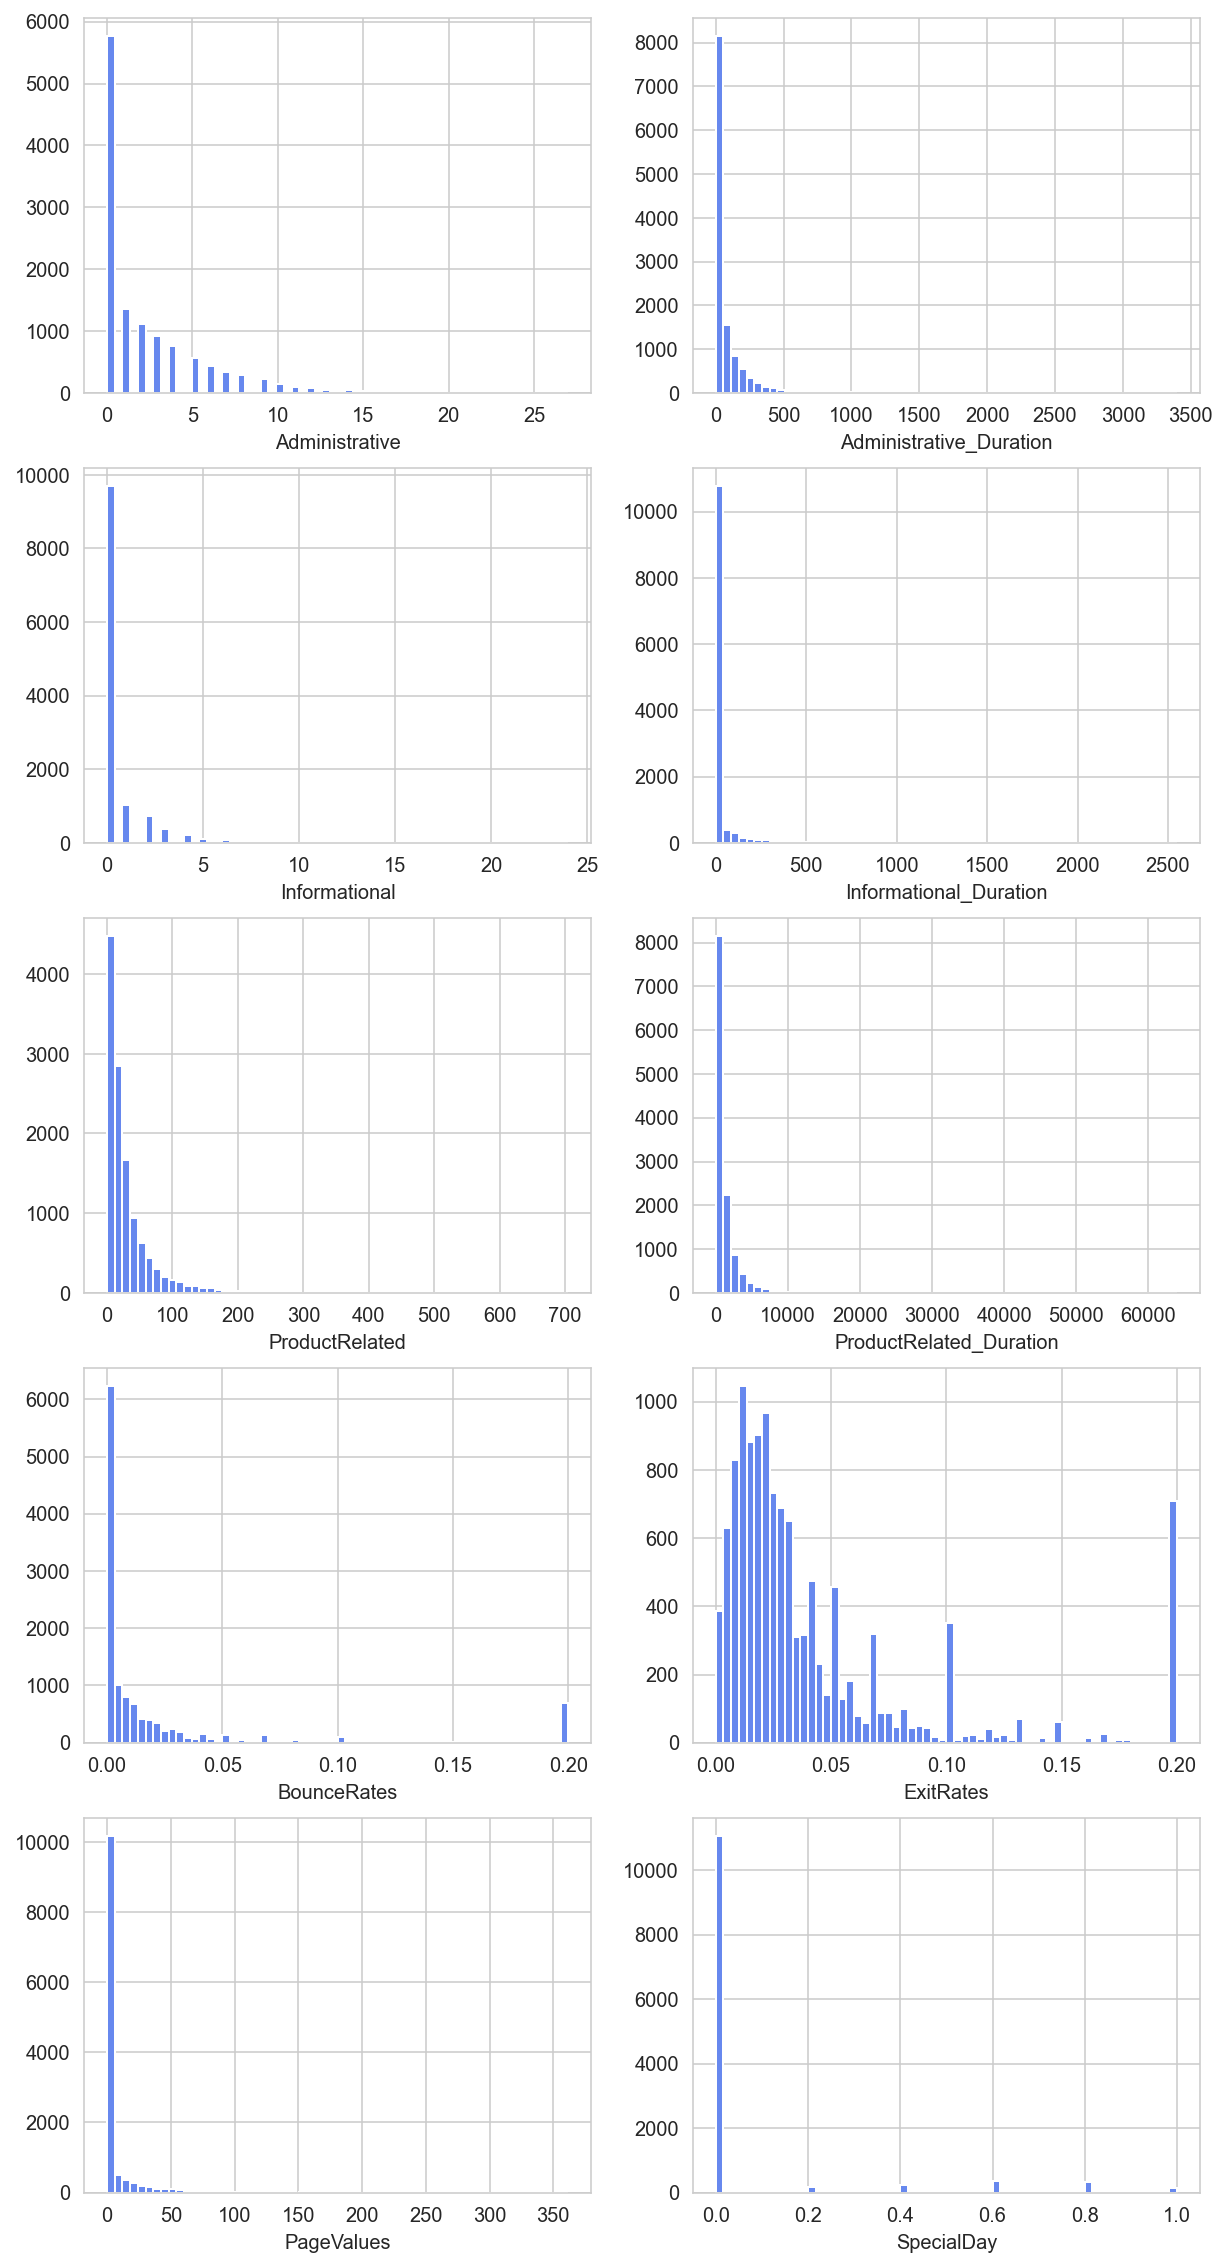

In [14]:
plot_hists(df, numeric, basic_color, 5, 2)

Распределение некоторых переменных напоминает логнормальное. Логарифмируем их, чтобы посмотреть, насколько данные станут похожи на нормальное распределение.

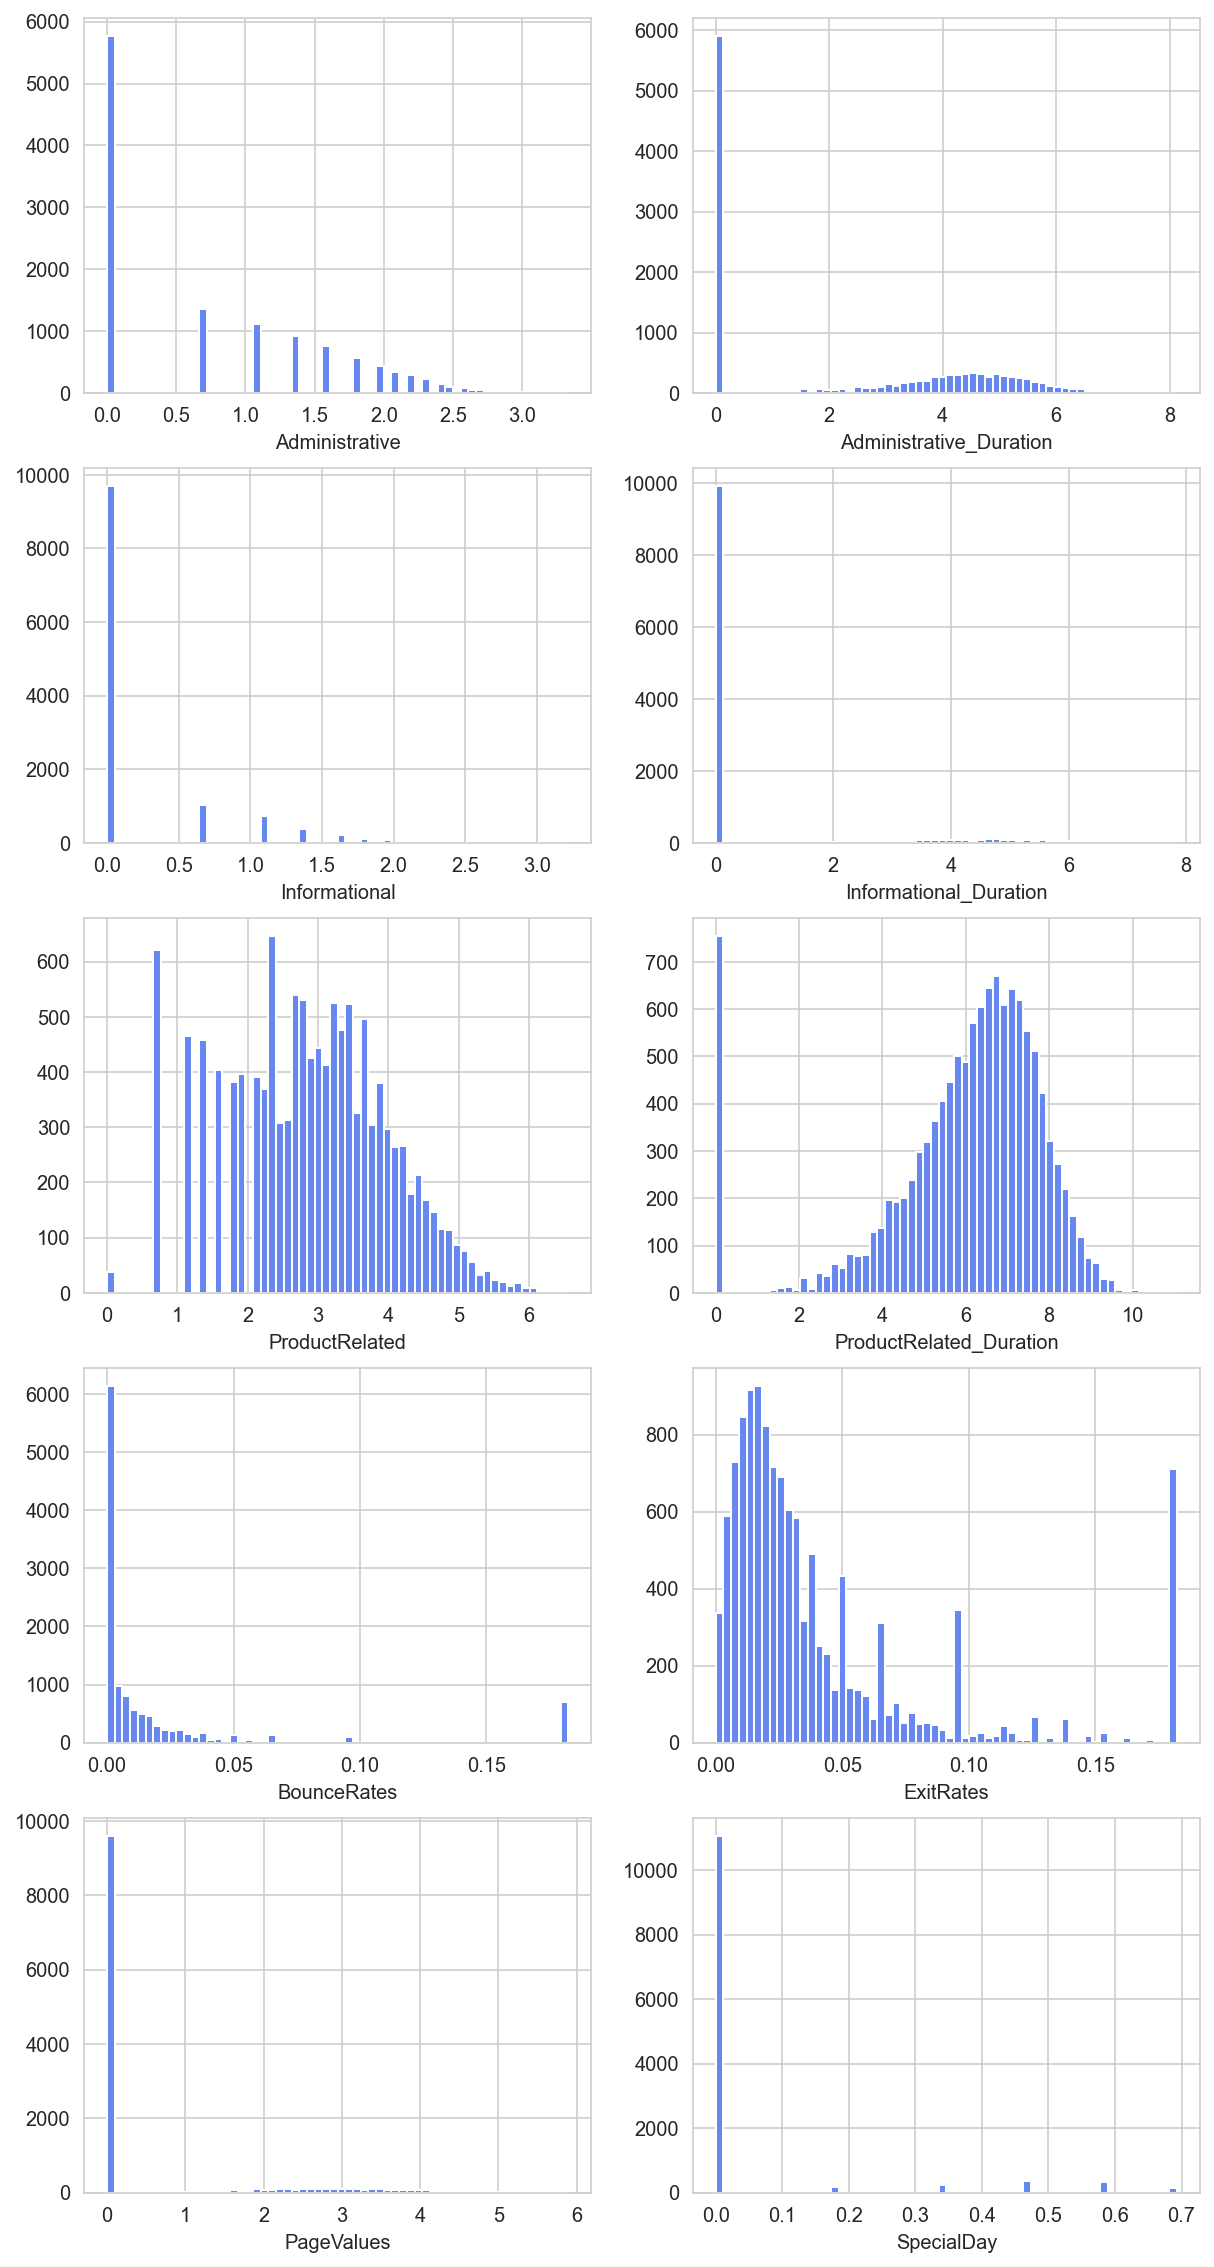

In [15]:
plot_log_hists(df, numeric, basic_color, 5, 2)

Есть смысл прологарифмировать переменные *ProductRelated_Duration*, *ExitRates* и *ProductRelated*.

In [16]:
for i in ['ProductRelated_Duration', 'ExitRates', 'ProductRelated']:
    df[f'Log{i}'] = np.log1p(df[i])
    
numeric = ['Administrative', 'Administrative_Duration', 'Informational',
           'Informational_Duration', 'LogProductRelated', 'LogProductRelated_Duration',
           'BounceRates', 'LogExitRates', 'PageValues', 'SpecialDay']

df = df[numeric + categ]

Посмотрим на выбросы с помощью ящика с усами:

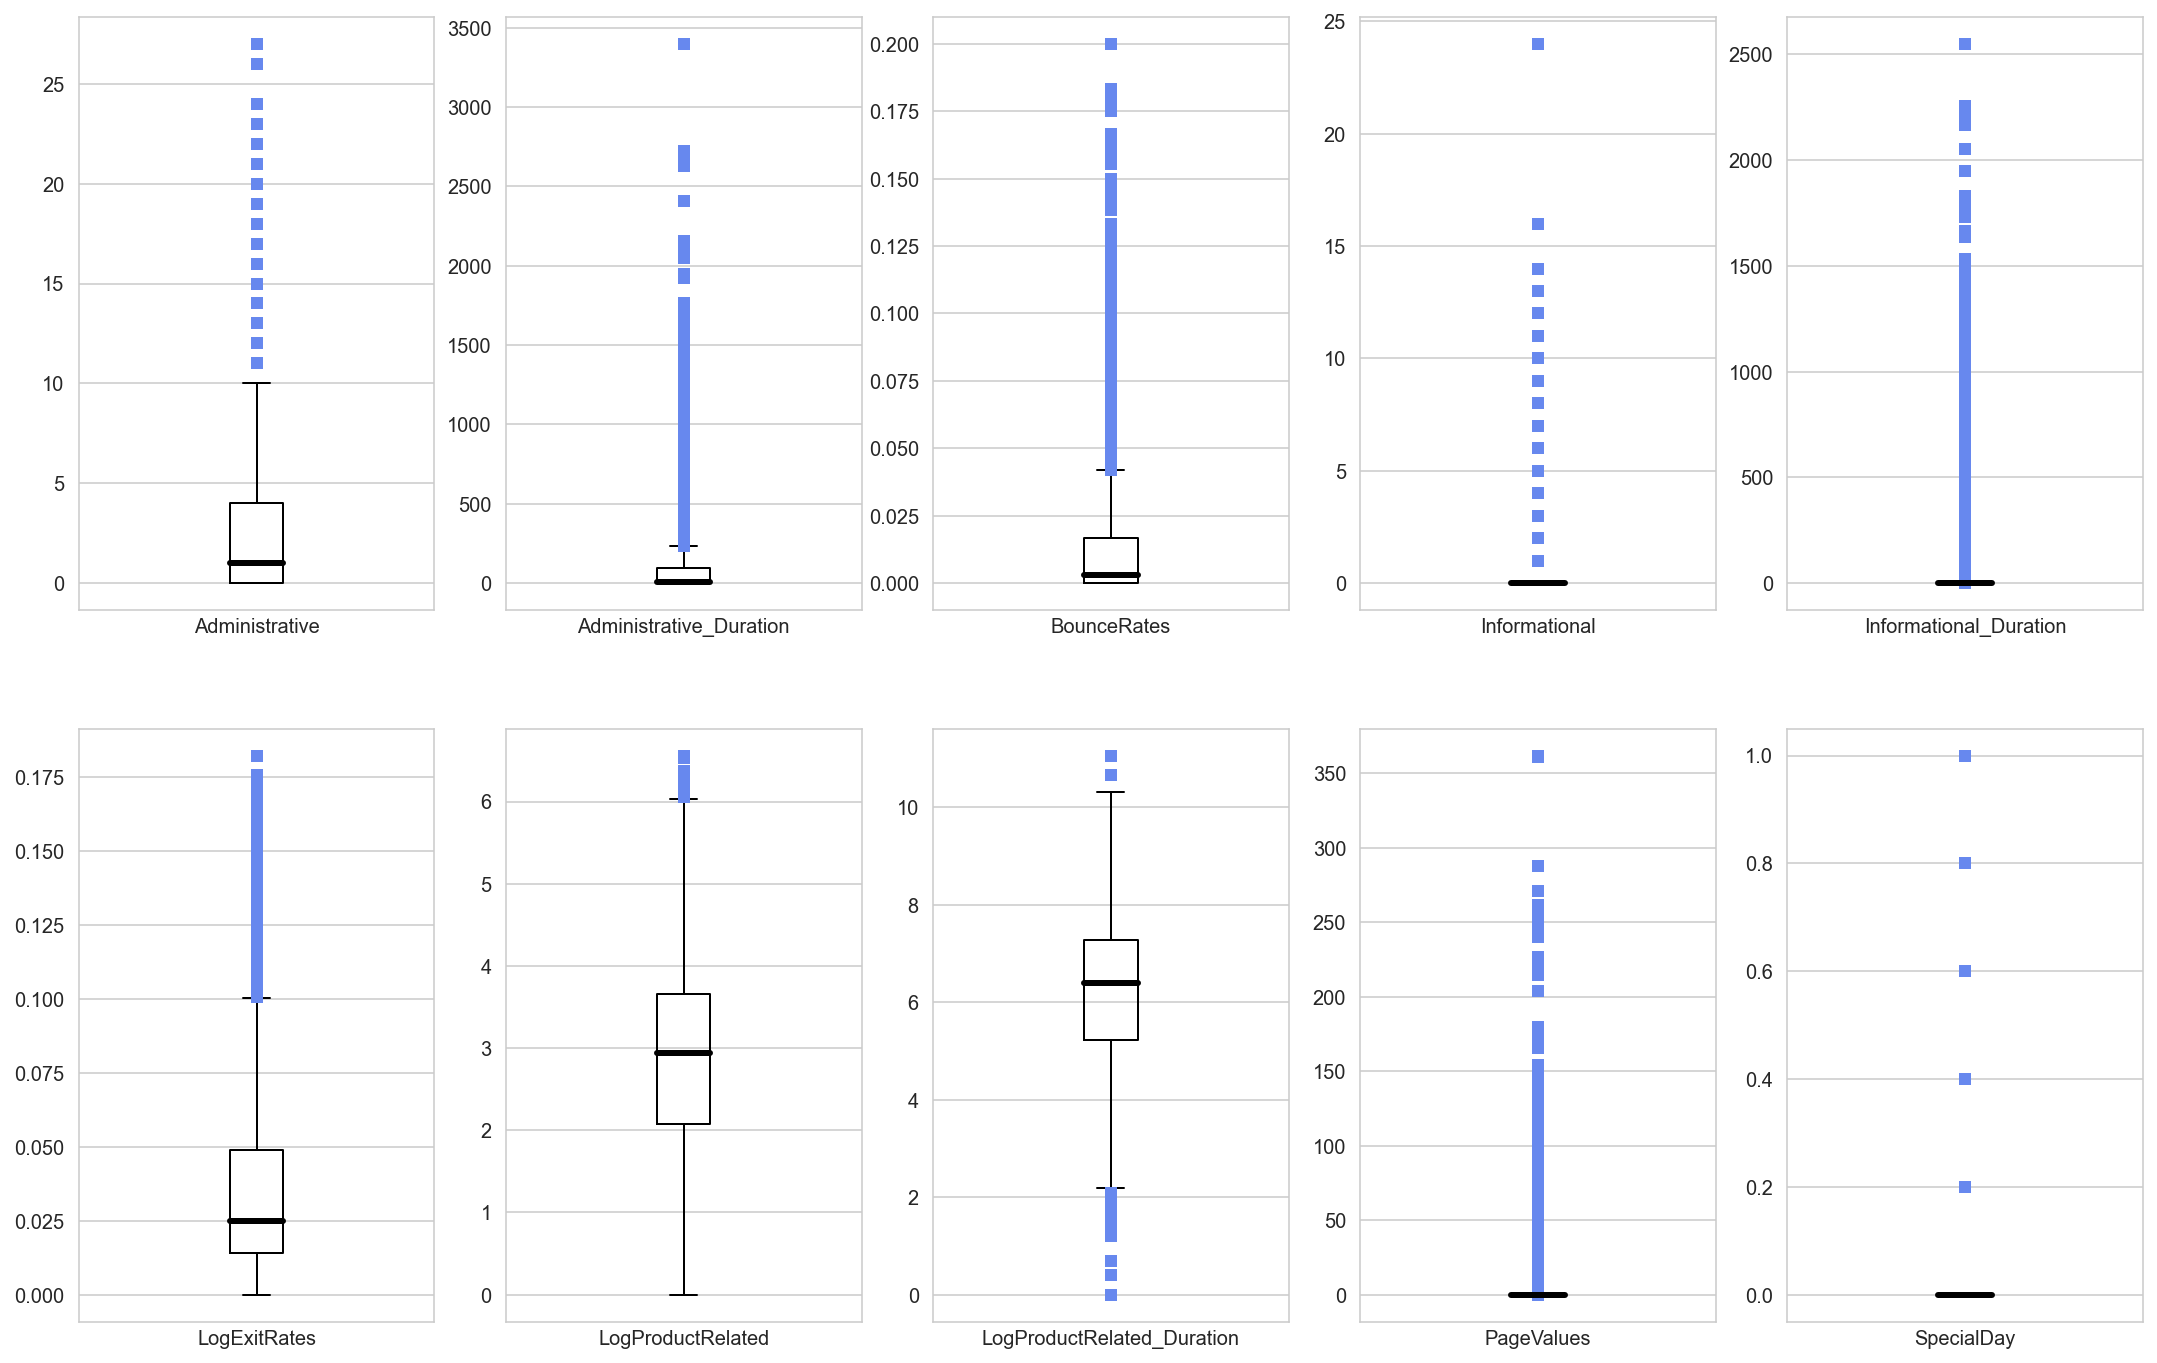

In [17]:
plot_boxplots(df, sorted(numeric), basic_color, 2, 5)

Объектов, визуально напоминающих выбросы, у нас не наблюдается. Голубые объекты находятся выше усов из-за большой дисперсии.

### Категориальные переменные

Для каждой категориальной переменной нарисуем линейчатый график, чтобы визуализировать категории и выявить незначительные. Незначительными по умолчанию назовем те, которые составляют менее 2% значений признака (будут выделены оранжевым цветом). Сильно повышать порог незначительности не стоит: это может привести к чрезмерному "выравниванию" объектов, что затруднит выявление четких сегментов.

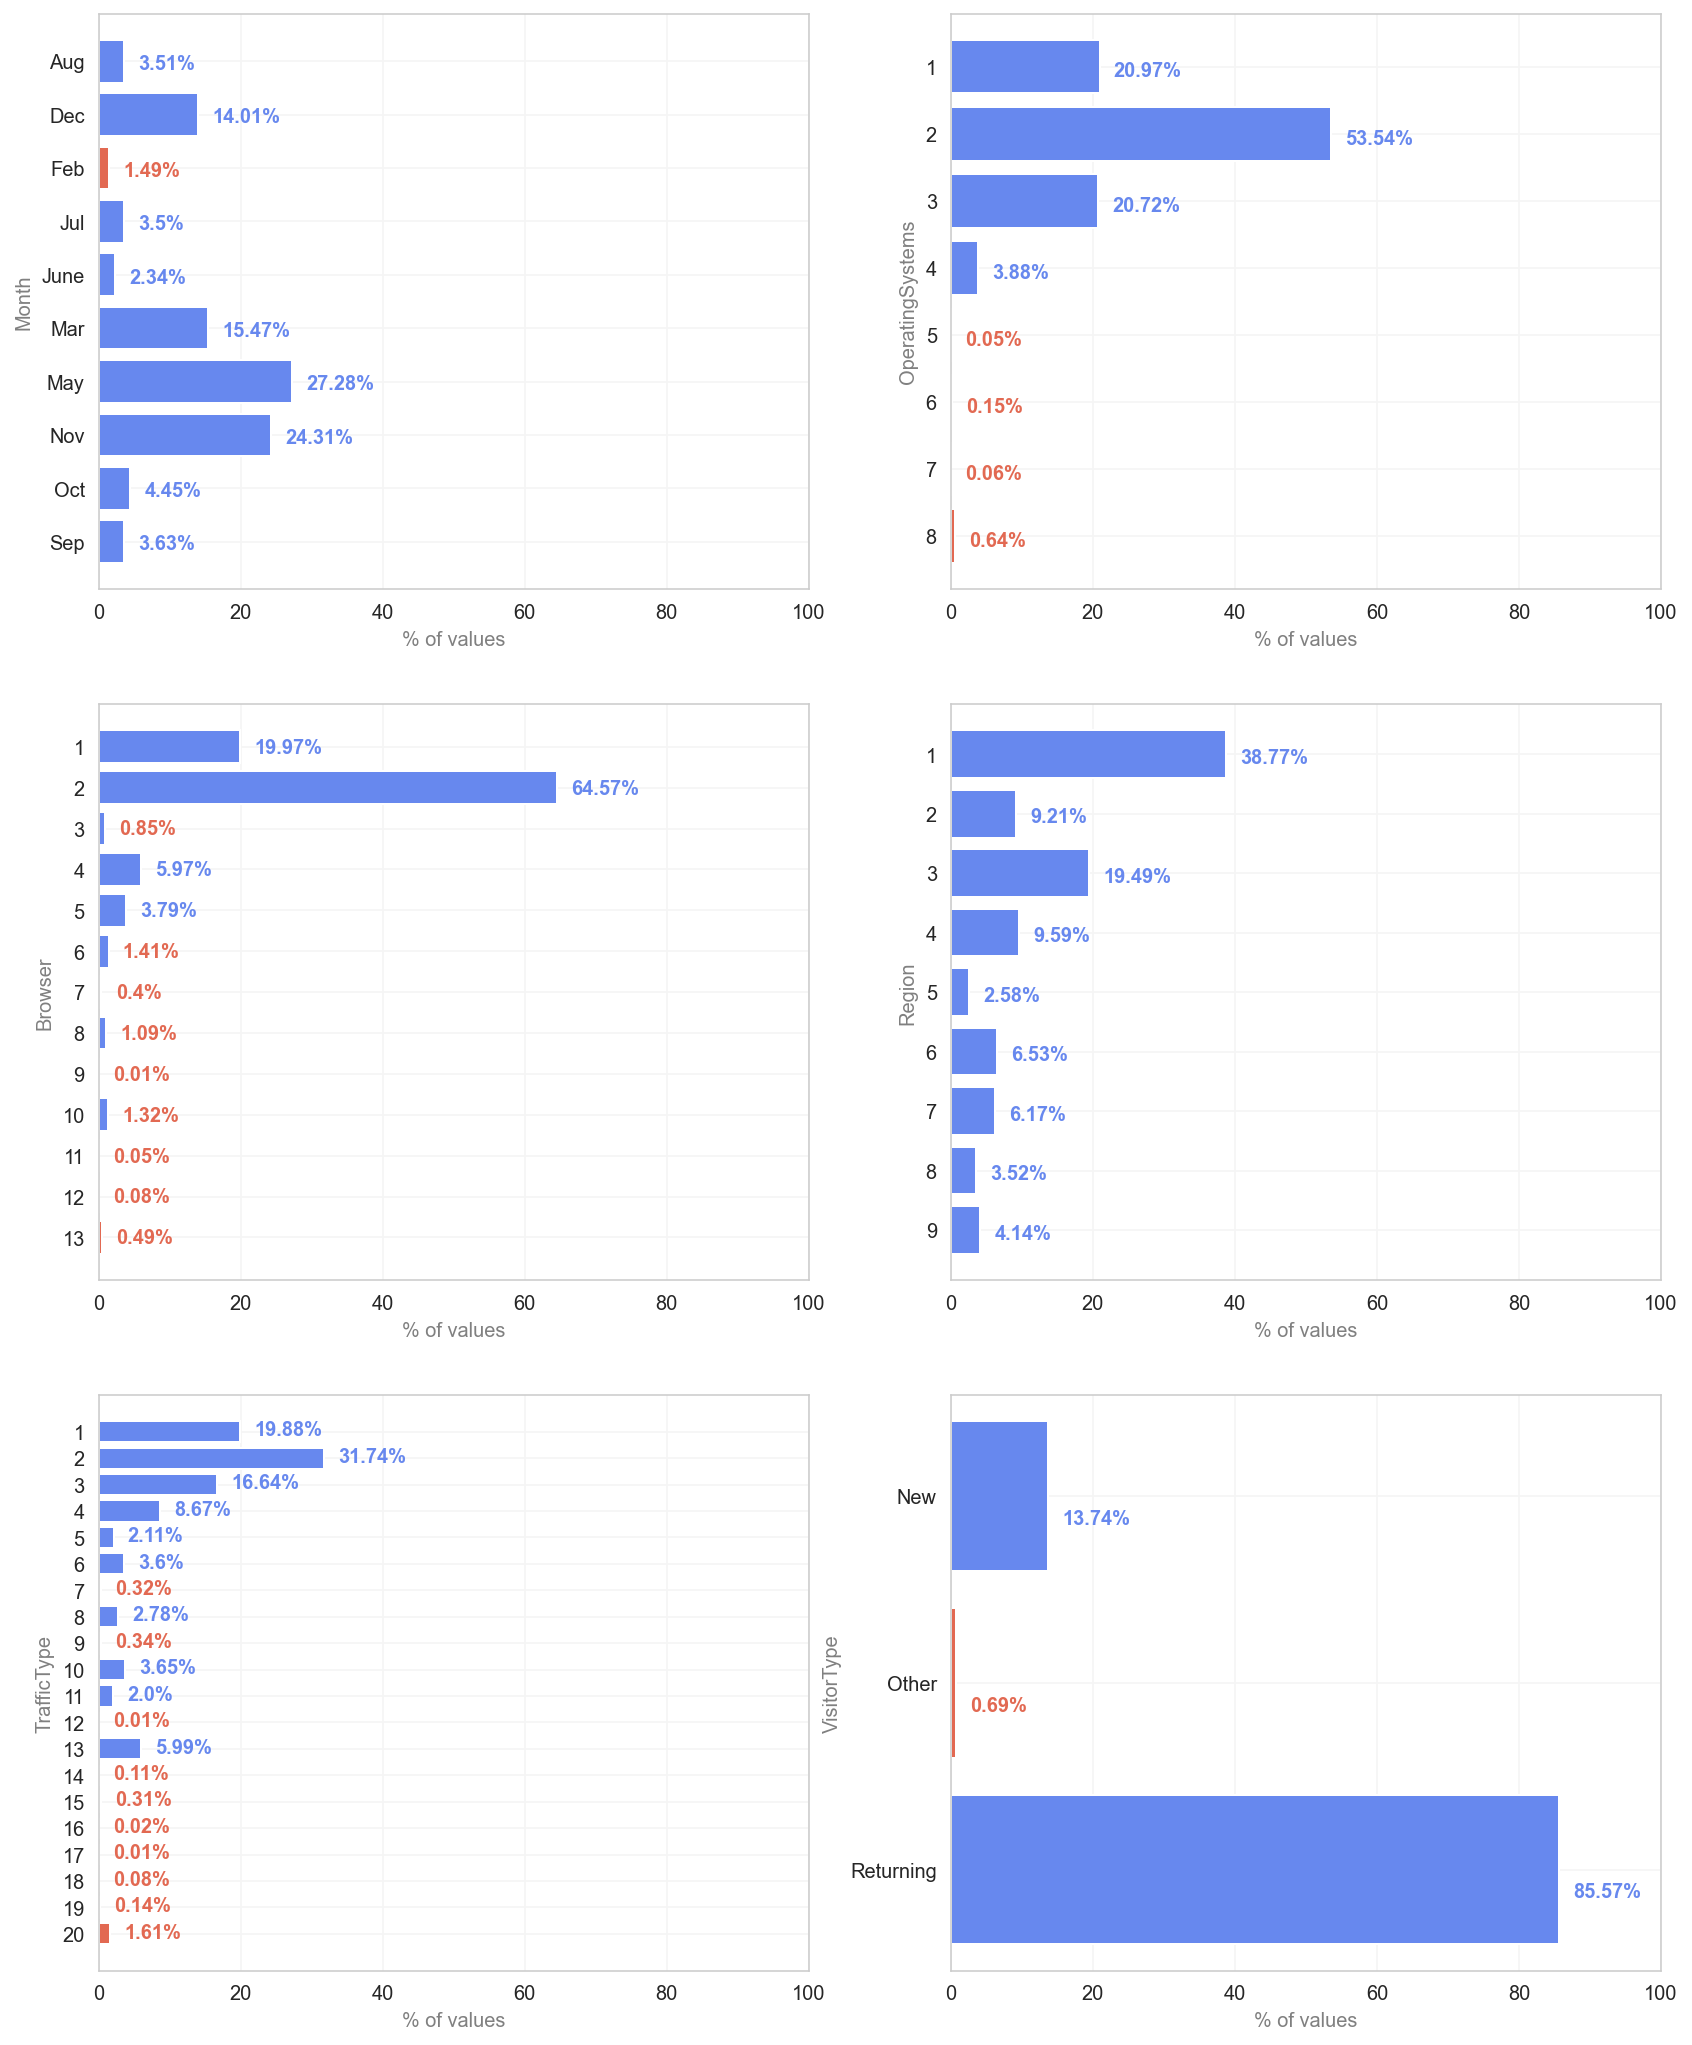

In [18]:
plot_barcharts(df, categ[:6], 'Administrative', 'str', basic_color, highlt_color, 3, 2)

По графикам заметно, что некоторые категории можно объединить, а некоторые - удалить, если в них практически нет наблюдений:

- у переменной Month хотя категория "Feb" и очень мала, но ее трогать не будем, потому что она характеризует конкретный месяц
- у переменной OperatingSystems удалим категории 5, 6, 7, 8
- у переменной Browser категории 6, 8, 10 добавим в категорию 3. Остальные (7, 9, 11, 12, 13) удалим
- у переменной TrafficType удалим категории 7, 9, 12, 14-20
- у переменной VisitorType удалим категорию "Other"

In [19]:
# удаляем записи с категориями 5, 6, 7, 8 для переменной OperatingSystems
df = df[~df['OperatingSystems'].isin([5, 6, 7, 8])]

# заменяем категории 6, 8, 10 на 3 для переменной Browser
df.loc[df['Browser'].isin([6, 8, 10]), 'Browser'] = 3

# удаляем записи с категориями 7, 9, 11, 12, 13 для переменной Browser
df = df[~df['Browser'].isin([7, 9, 11, 12, 13])]

# удаляем записи с категориями 7, 9, 12, 14-20 для переменной TrafficType
df = df[~df['TrafficType'].isin([7, 9, 12, 14, 15, 16, 17, 18, 19, 20])]

# удаляем записи с категорией "Other" для переменной VisitorType
df = df[df['VisitorType'] != 'Other']

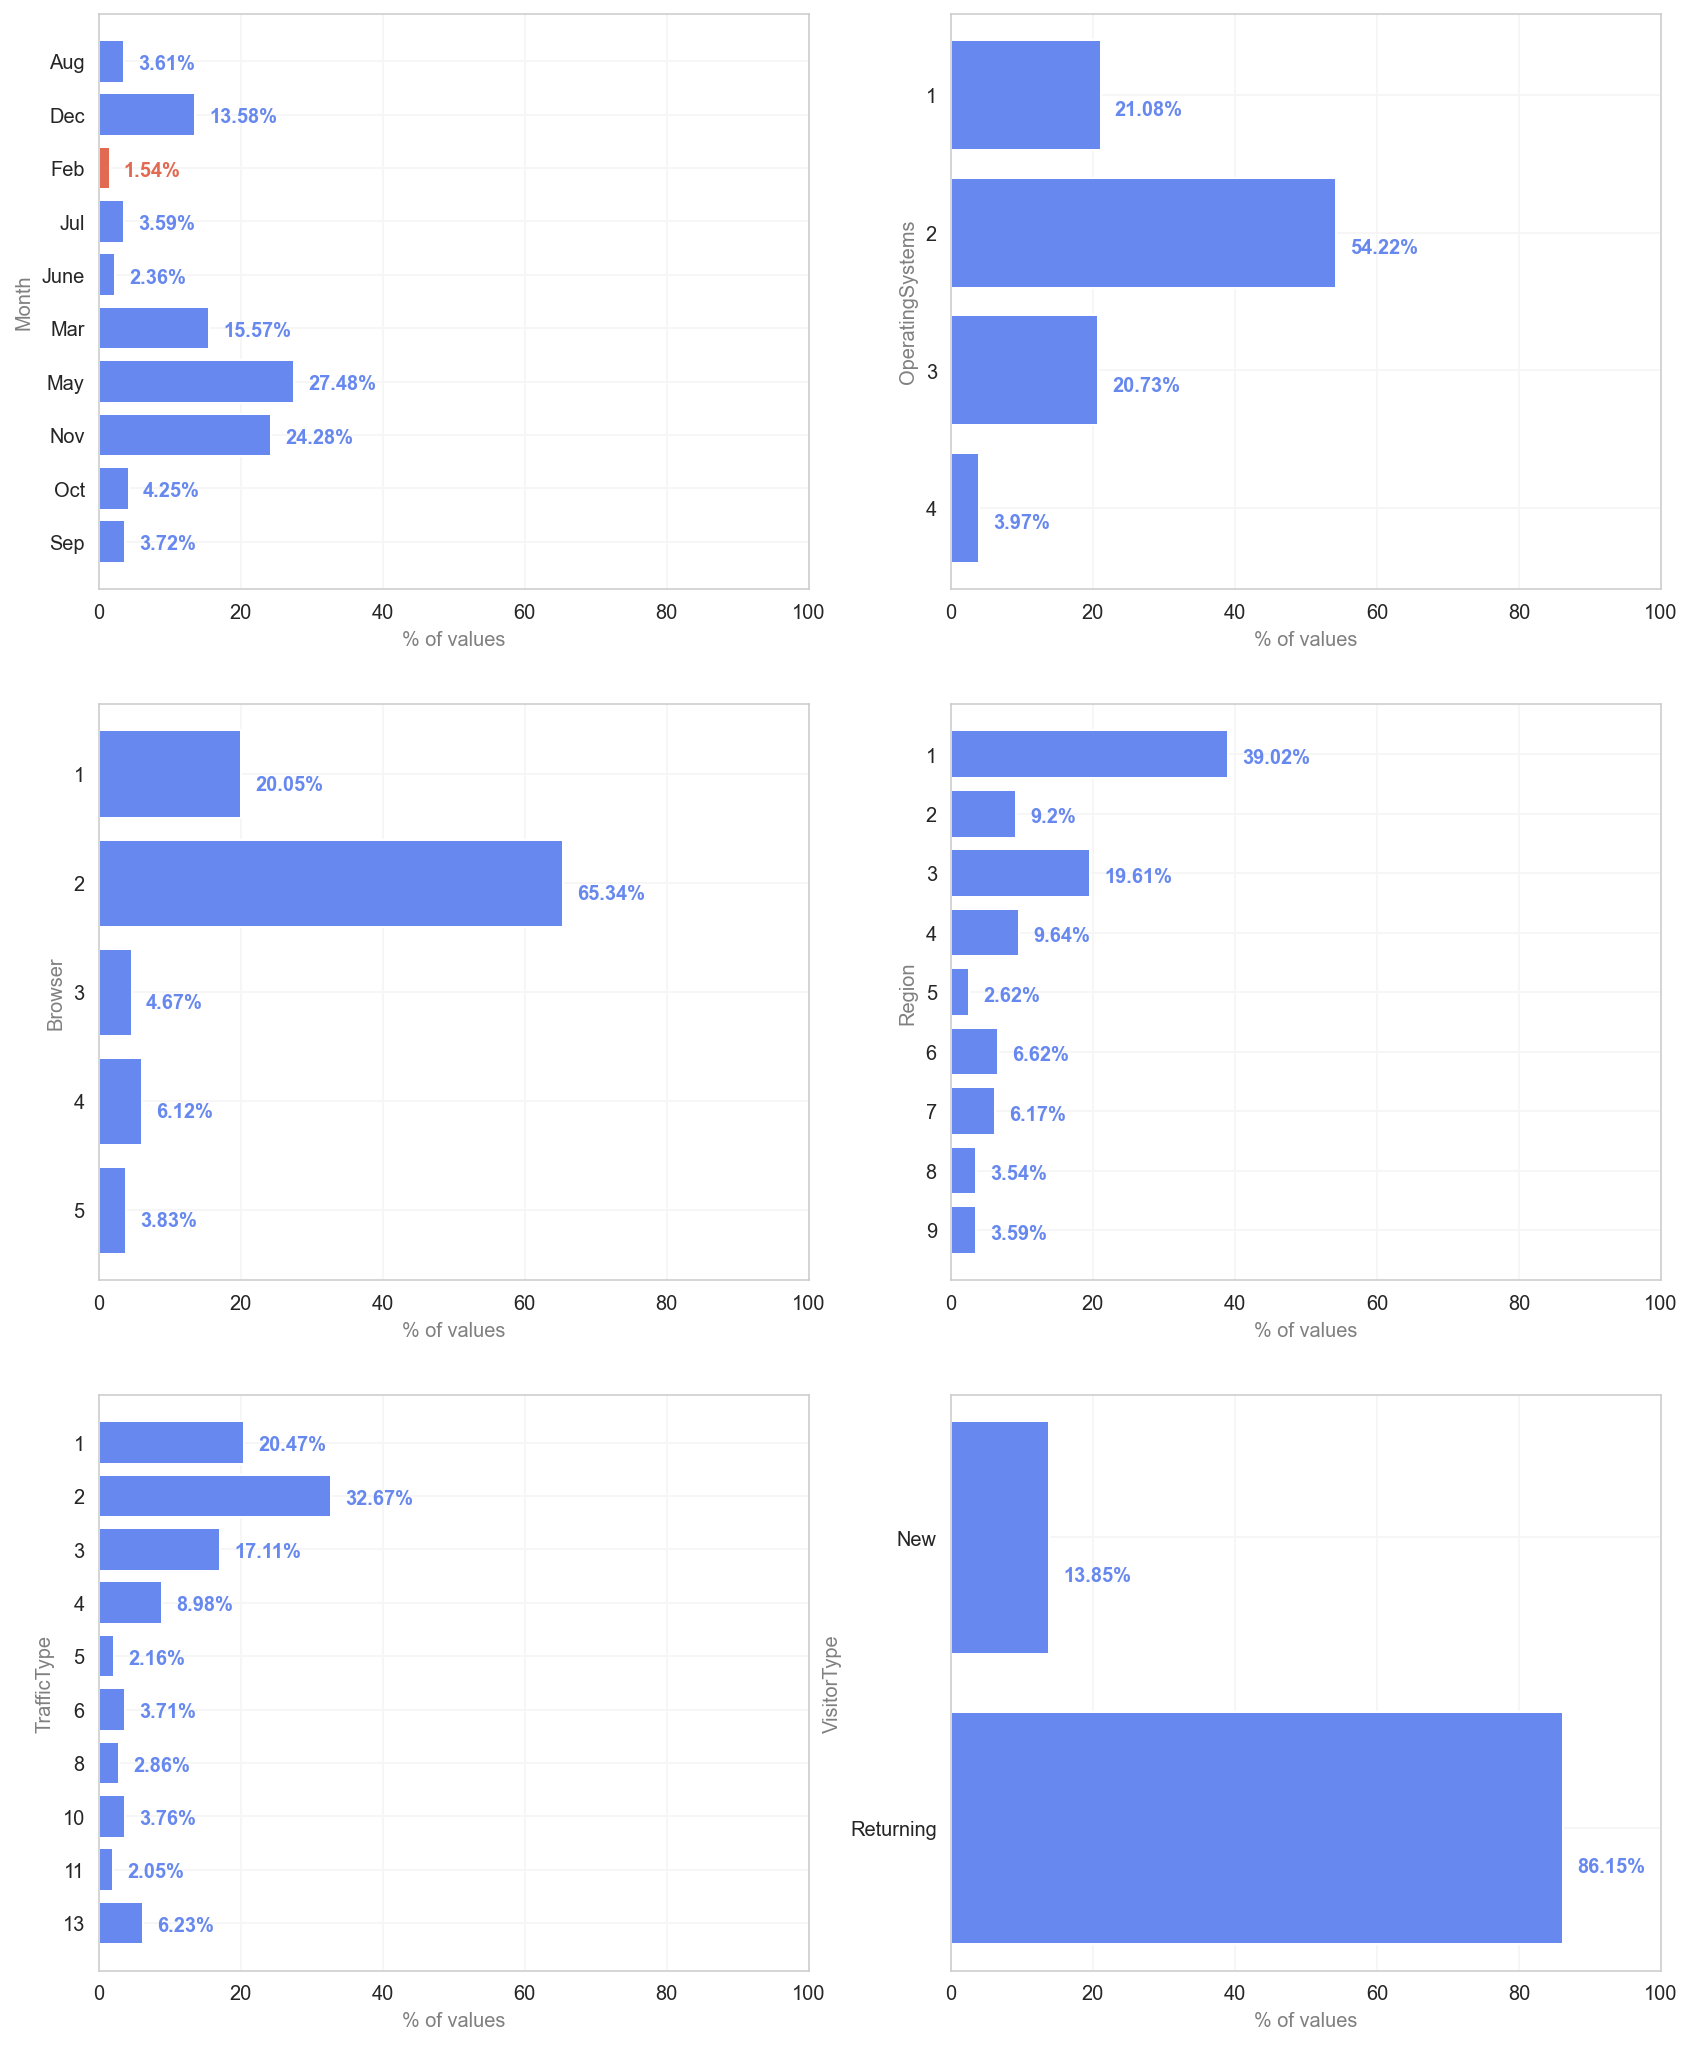

In [20]:
plot_barcharts(df, categ[:6], 'Administrative', 'str', basic_color, highlt_color, 3, 2)

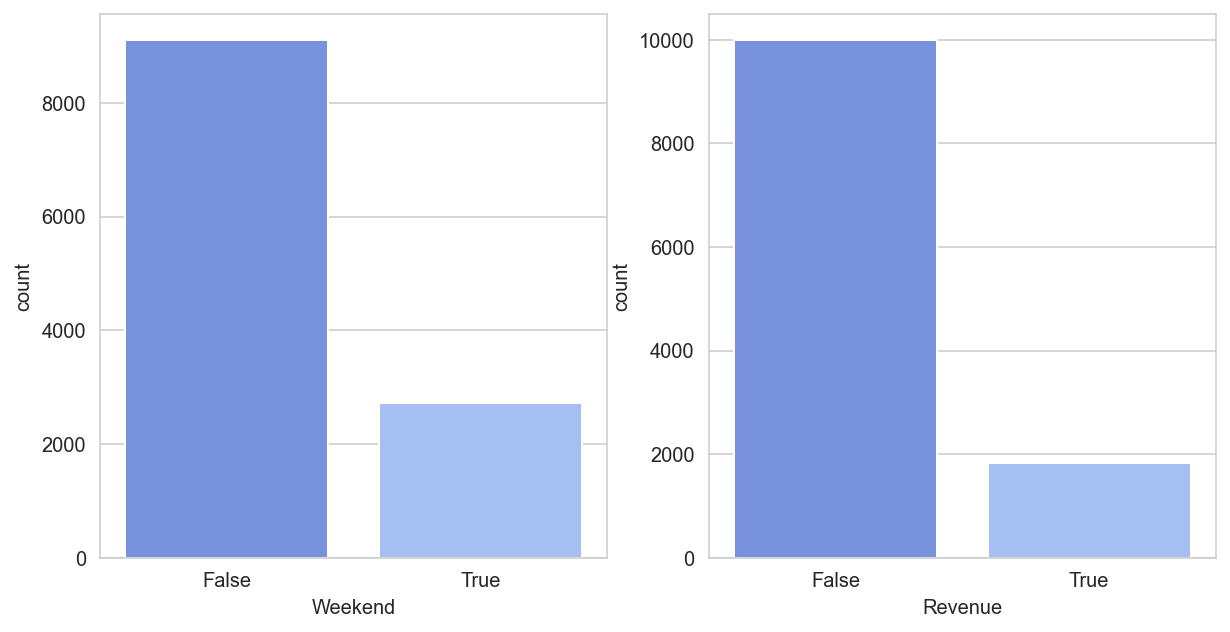

In [21]:
# распределение бинарных переменных
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='Weekend', data=df[categ], ax=axs[0])
sns.countplot(x='Revenue',data=df[categ], ax=axs[1])
plt.show()

## 2.4. Feature Engineering
Источник: https://ubc-mds.github.io/online-shoppers-purchasing-intention/intro.html#data-cleaning-feature-engineering

In [22]:
# % просмотров страниц ProductRelated
prod_rel = np.exp(df['LogProductRelated']) - 1
pages_sum = df['Administrative'] + df['Informational'] + prod_rel
df['ProductRelatedPrc'] = prod_rel / pages_sum

# % длительности просмотров у ProductRelated
prod_rel_dur = np.exp(df['LogProductRelated_Duration']) - 1
dur_sum = df['Administrative_Duration'] + df['Informational_Duration'] + prod_rel_dur
df['ProductRelated_Duration_Prc'] = prod_rel_dur / dur_sum

# средняя продолжительность просмотра страницы у ProductRelated
df['Av_ProductRelated_Duration'] = prod_rel_dur / prod_rel

# ценность на одну страницу ProductRelated
df['PageValues_ProductRelated'] = df['PageValues'] / prod_rel

# ценность на секунду просмотра ProductRelated
df['PageValues_ProductRelatedDuration'] = df['PageValues'] / prod_rel_dur

In [23]:
df.isna().sum()

Administrative                         0
Administrative_Duration                0
Informational                          0
Informational_Duration                 0
LogProductRelated                      0
LogProductRelated_Duration             0
BounceRates                            0
LogExitRates                           0
PageValues                             0
SpecialDay                             0
Month                                  0
OperatingSystems                       0
Browser                                0
Region                                 0
TrafficType                            0
VisitorType                            0
Weekend                                0
Revenue                                0
ProductRelatedPrc                      5
ProductRelated_Duration_Prc          662
Av_ProductRelated_Duration            34
PageValues_ProductRelated             34
PageValues_ProductRelatedDuration    697
dtype: int64

In [24]:
df.dropna(inplace=True)

Исследуем распределение новых переменных:

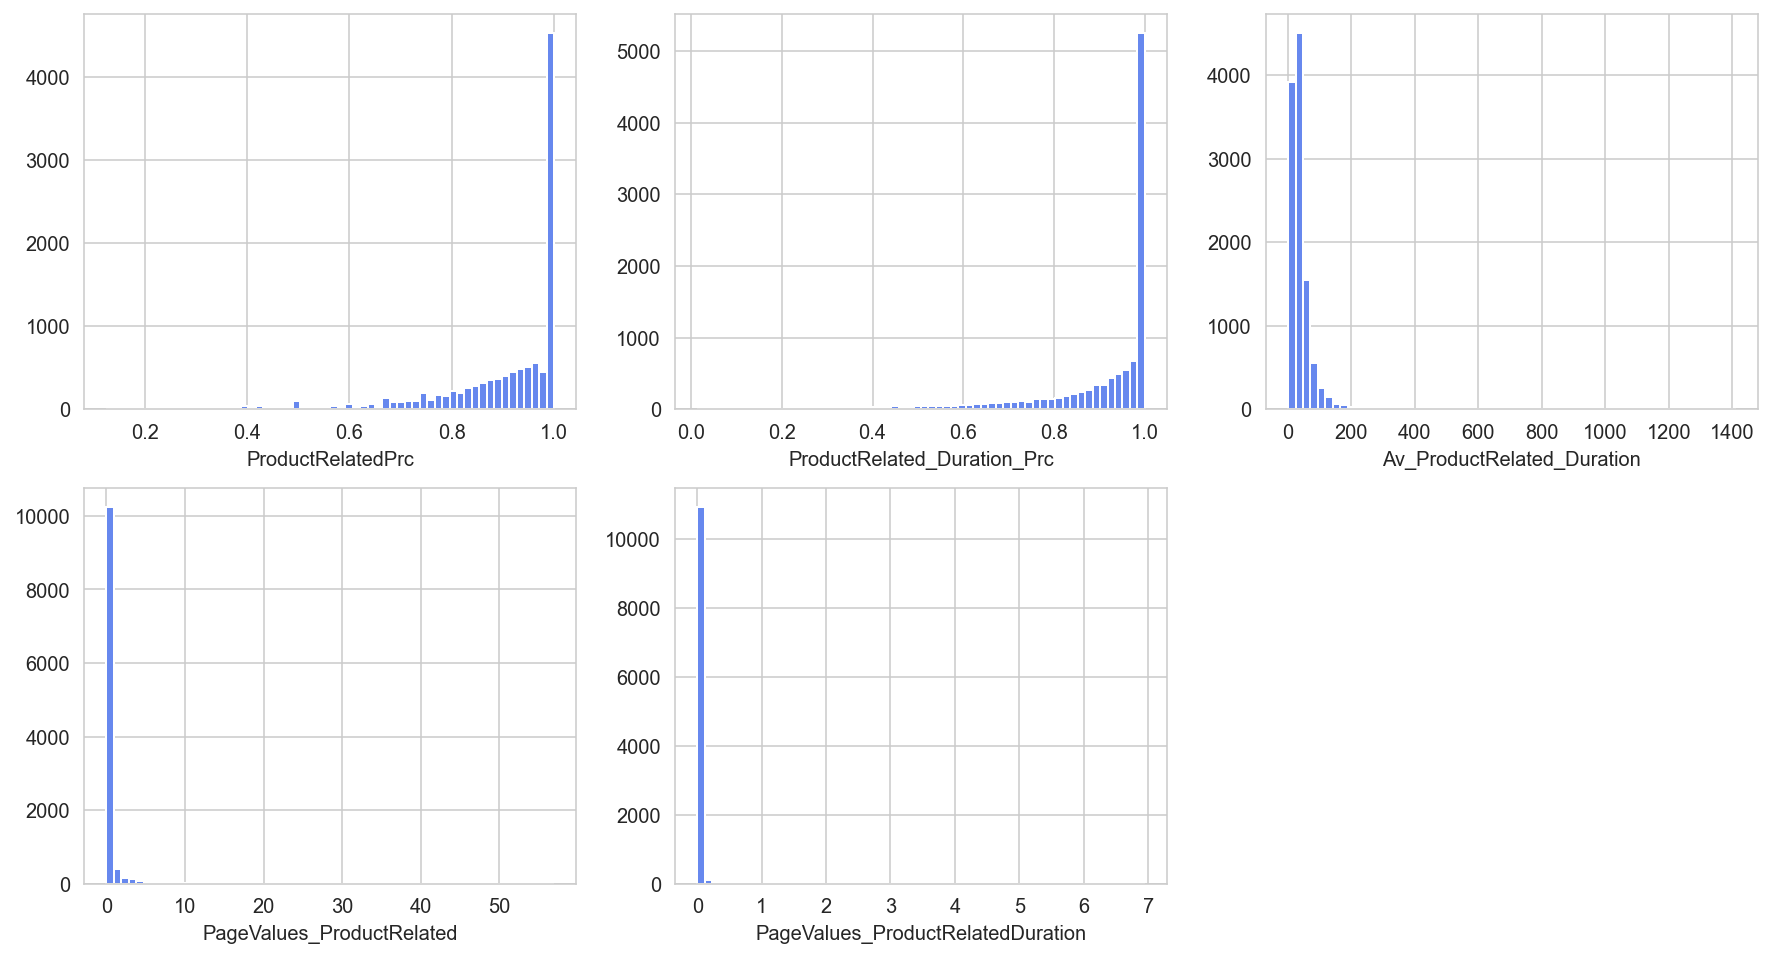

In [25]:
new = ['ProductRelatedPrc', 'ProductRelated_Duration_Prc',
       'Av_ProductRelated_Duration', 'PageValues_ProductRelated',
       'PageValues_ProductRelatedDuration']

plot_hists(df, new, basic_color, 2, 3)

Возможно, некоторые переменные нужно логарифмировать.

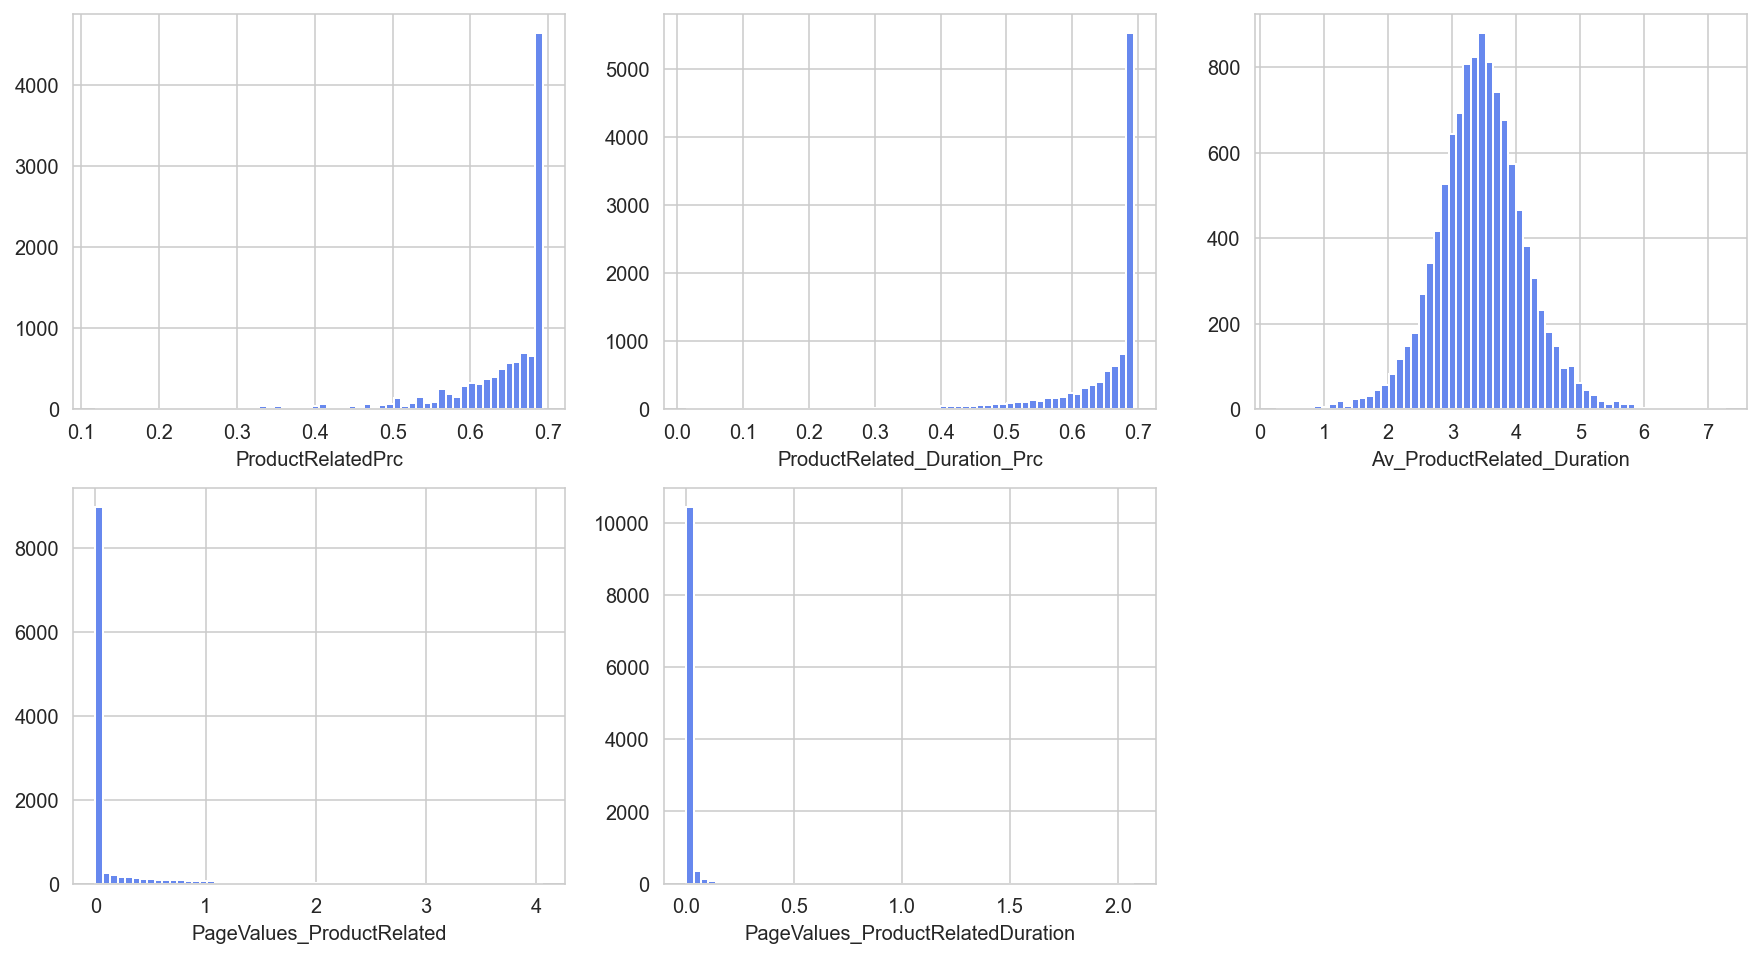

In [26]:
plot_log_hists(df, new, basic_color, 2, 3)

Имеет смысл логарифмировать *Av_ProductRelated_Duration*.

In [27]:
df[f'LogAv_ProductRelated_Duration'] = np.log1p(df['Av_ProductRelated_Duration'])
df.drop(columns=['Av_ProductRelated_Duration'], inplace=True)

## 2.5. Корреляционный анализ

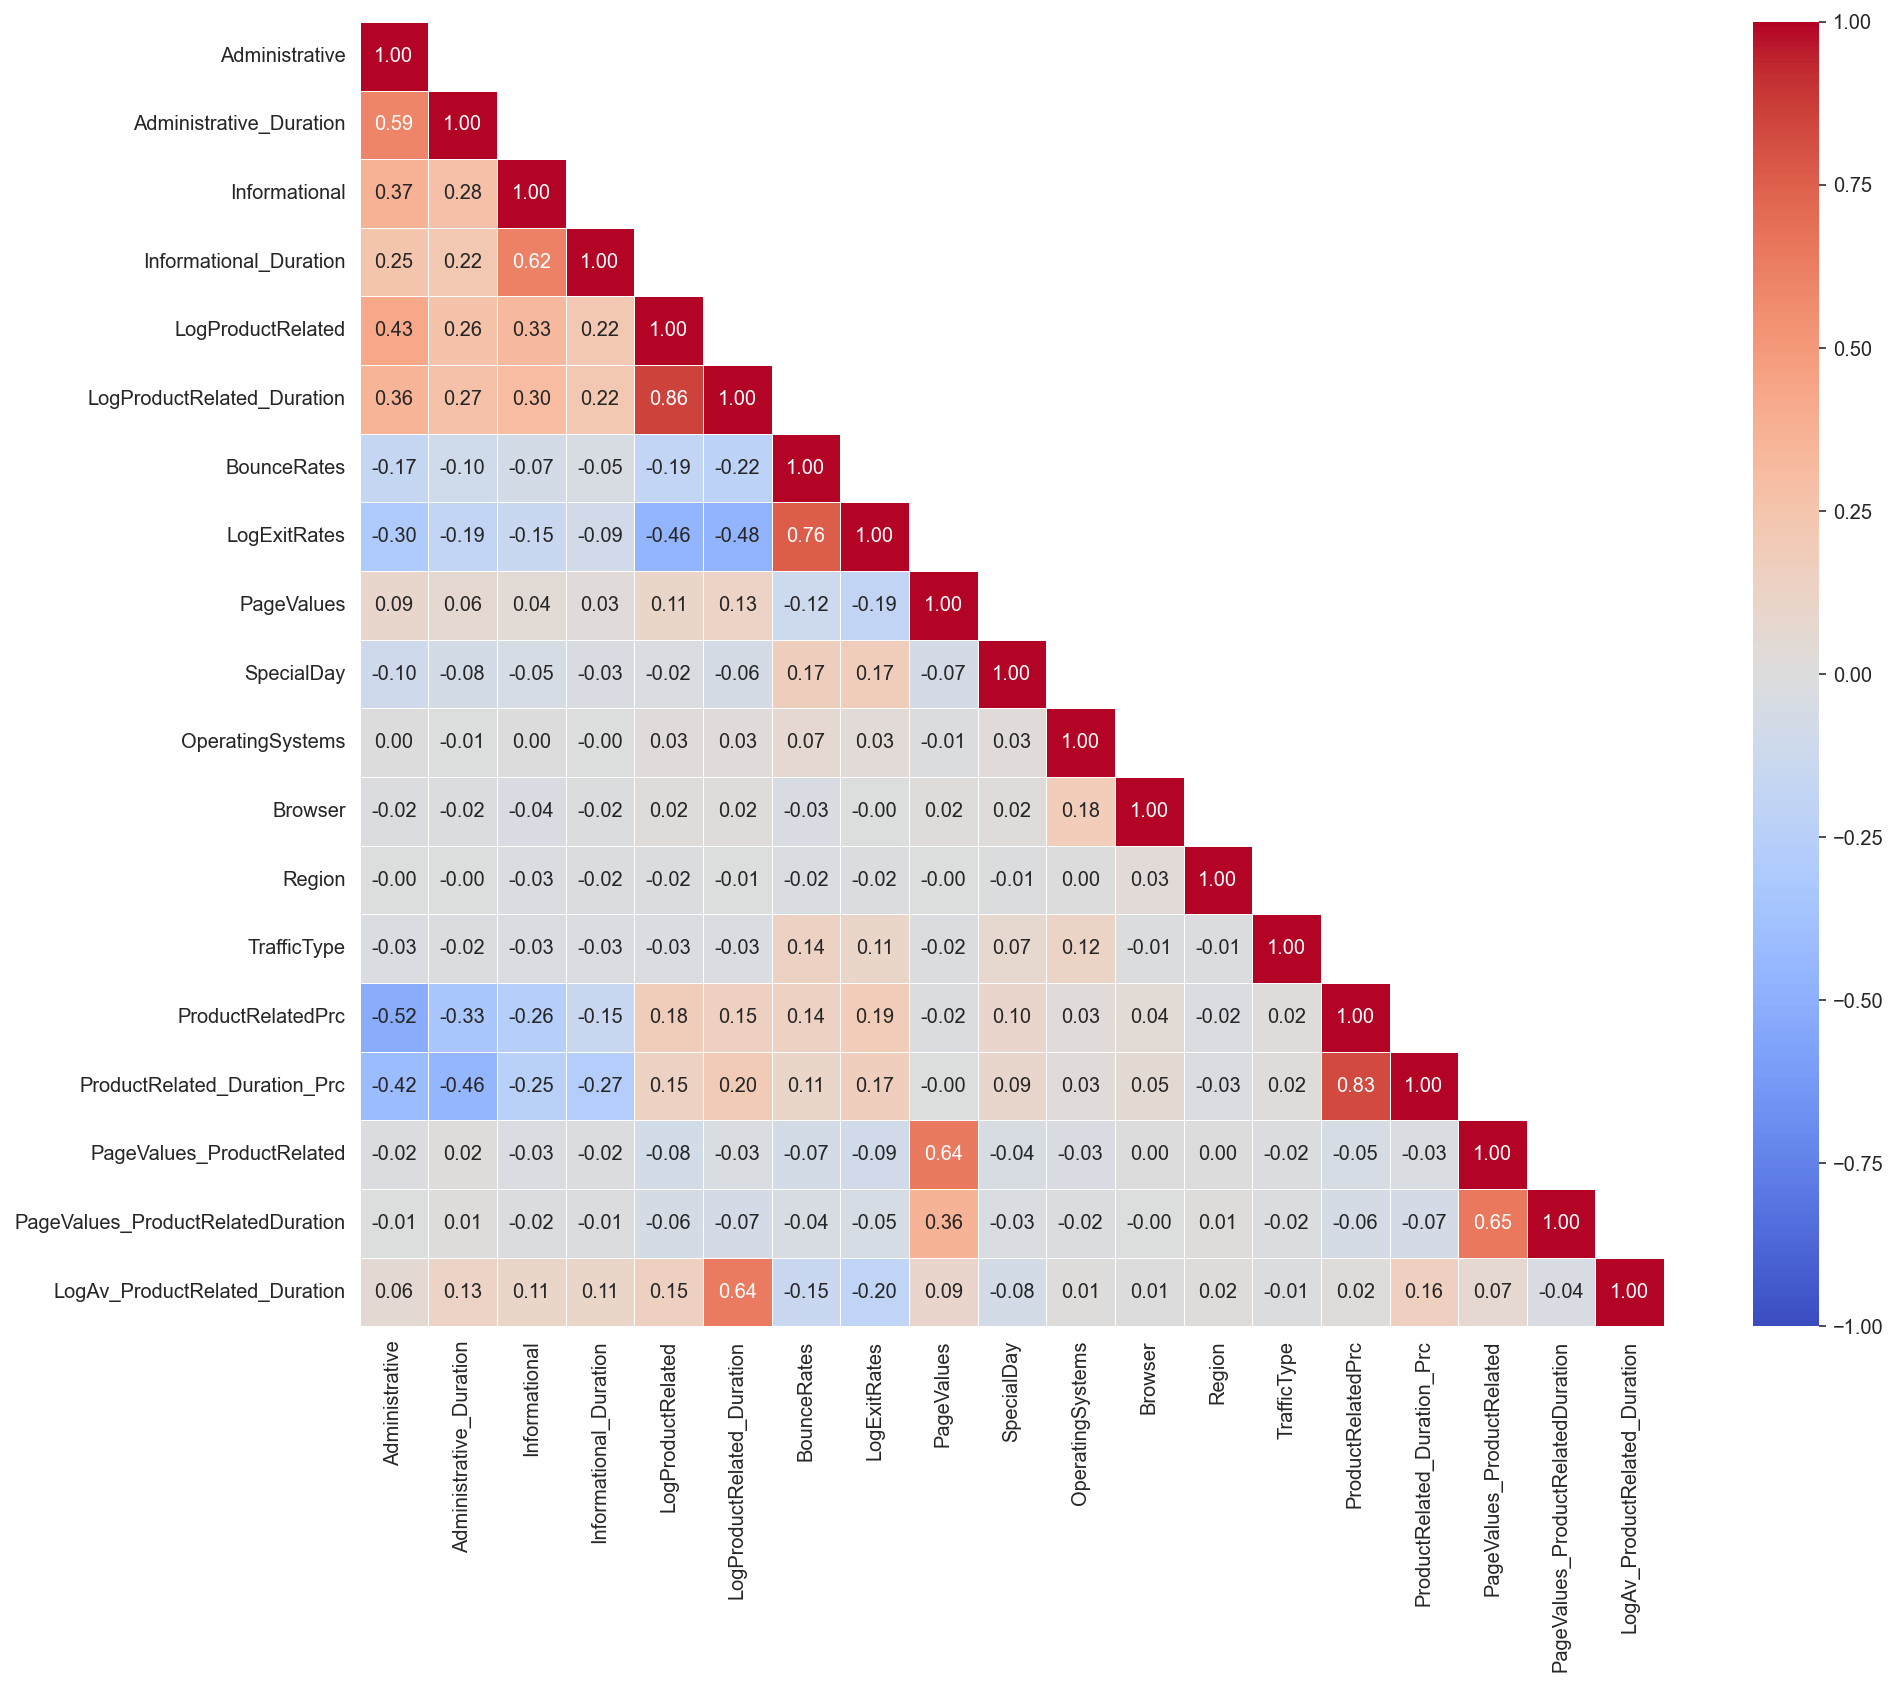

In [28]:
numeric_features = df.select_dtypes(include=['int', 'float']).columns
plot_corr(df, numeric_features, l=16, w=12, main=True)

Сильная корреляция:
- между *LogProductRelated_Duration* и *LogProductRelated*
- между *LogExitRates* и *BounceRates*
- между *ProductRelatedPrc* и *ProductRelated_Duration_Prc*

Тем не менее удалять переменные не стоит, так как они несут важную информацию для модели.

# 3. Подготовка витрины данных

## 3.1. Восстановление информации
Барьер заключается в том, что данные о кодировке переменных *OperatingSystems*, *Browser*, *Region* и *TrafficType* не размещены в открытом доступе. В связи с этим нам нужно сделать некоторые предпосылки, чтобы внести в эти признаки содержательный смысл для дальнейшей интерпретации сегментов.

Мы предполагаем, что наша выборка репрезентативна, а значит может отражать генеральную совокупность. Выборка была собрана с сайта магазина Columbia в Турции в августе 2018 года, поэтому необходимо найти данные о топе операционных систем, браузеров, регионов и типов трафика на этот момент времени в этой стране. Далее мы расположим категории соответствующих переменных в порядке убывания и сопоставим их с найденными данными.

### Операционная система
Топ-4 операционных систем в Турции по месяцам, 2018 год: https://gs.statcounter.com/os-market-share/all/turkey/2018
1. Android
2. Windows
3. iOS
4. OS X

In [29]:
df['OperatingSystems'] = np.where(df['OperatingSystems'] == 2, 'Android',
                                  np.where(df['OperatingSystems'] == 1, 'Windows',
                                           np.where(df['OperatingSystems'] == 3, 'iOS', 'OS X')))

### Браузер

Топ-5 браузеров в Турции по месяцам, 2018 год: https://gs.statcounter.com/browser-market-share/all/turkey/2018
1. Chrome
2. Safari
3. Samsung Internet
4. Opera
5. Firefox

In [30]:
df['Browser'] = np.where(df['Browser'] == 2, 'Chrome',
                         np.where(df['Browser'] == 1, 'Safari',
                                  np.where(df['Browser'] == 4, 'Samsung Internet',
                                           np.where(df['Browser'] == 3, 'Opera', 'Firefox'))))

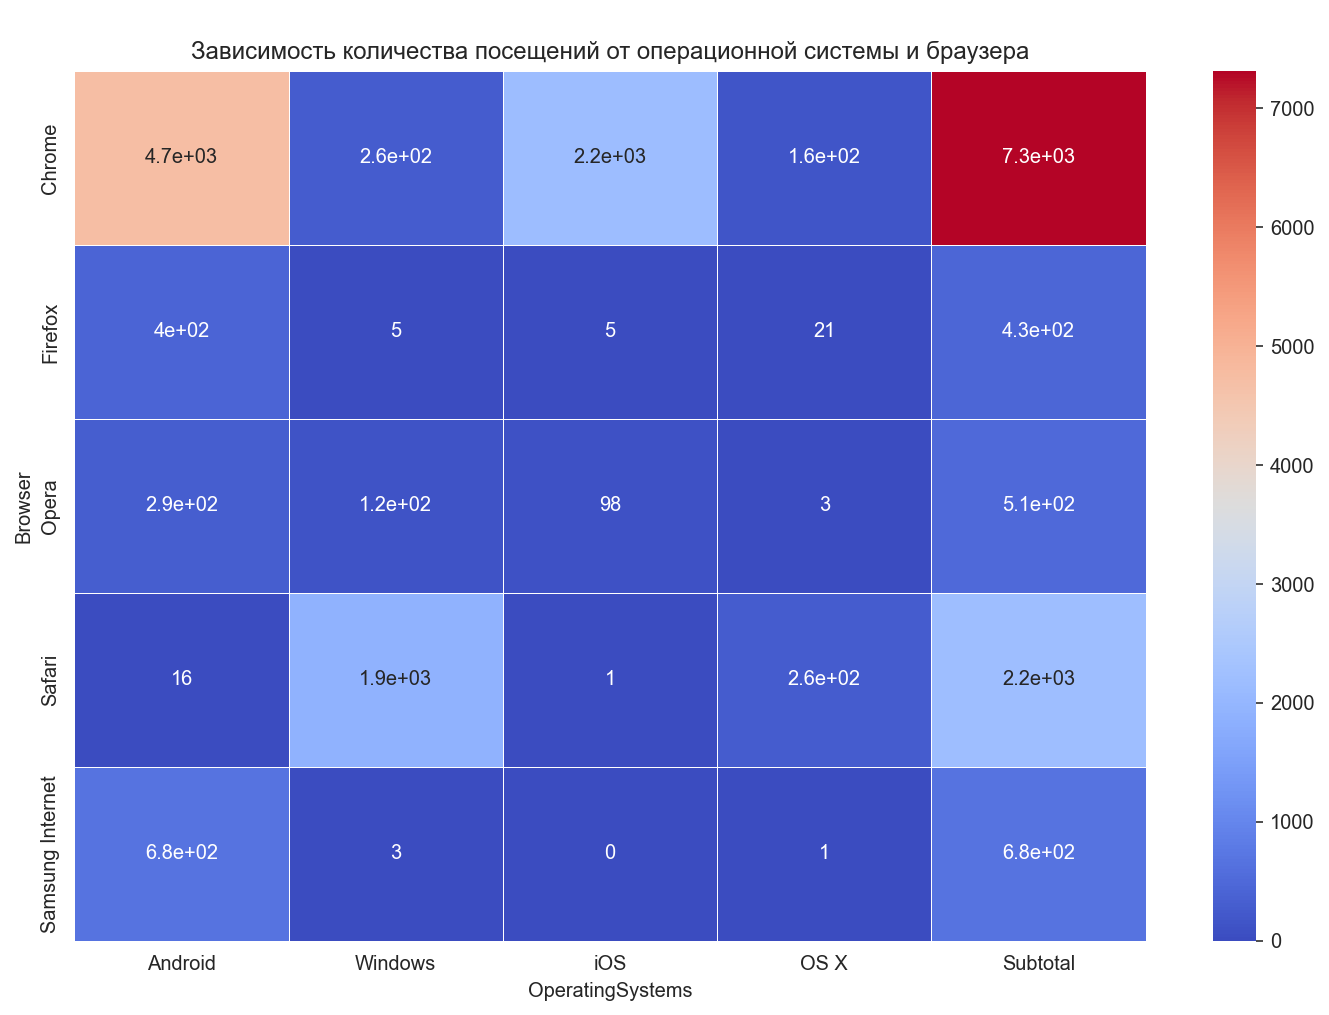

In [31]:
os = ['Android', 'Windows', 'iOS', 'OS X']

plot_count_target_map(df, ['OperatingSystems', 'Browser'], 'Revenue', os,
                      '\nЗависимость количества посещений от операционной системы и браузера')

Нелогично, что на ОС Windows браузером Safari пользуются около 2000 человек, а на ОС iOS - только один. Поменяем местами эти операционные системы.

In [32]:
df['OperatingSystems'] = np.where(df['OperatingSystems'] == 'Windows', 'iOS_',
                                  np.where(df['OperatingSystems'] == 'iOS', 'Windows',
                                           df['OperatingSystems']))

df['OperatingSystems'] = np.where(df['OperatingSystems'] == 'iOS_', 'iOS', df['OperatingSystems'])

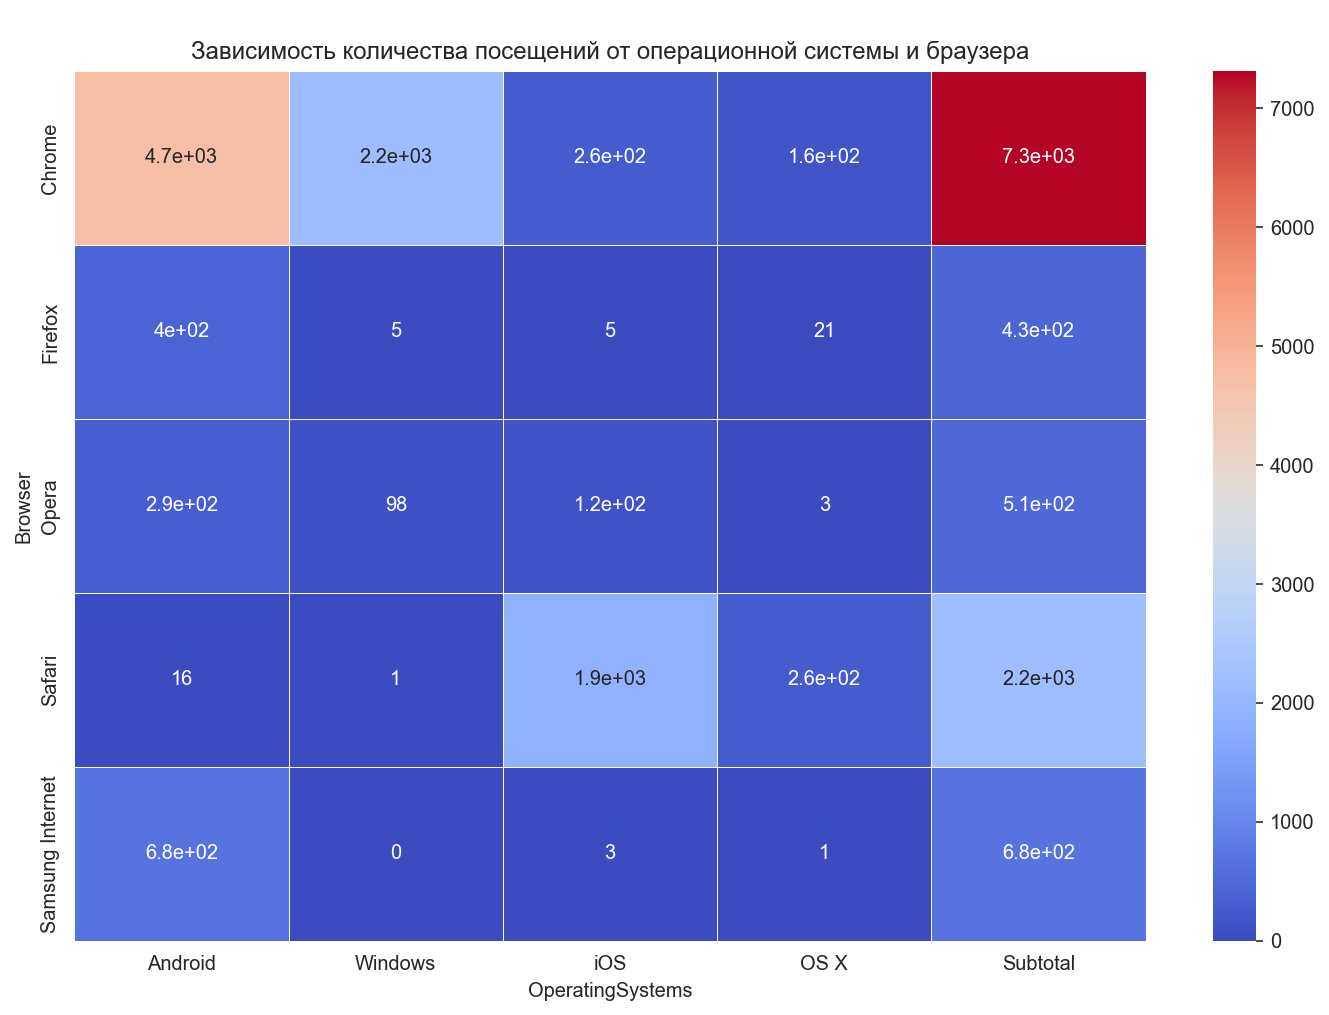

In [33]:
plot_count_target_map(df, ['OperatingSystems', 'Browser'], 'Revenue', os,
                      '\nЗависимость количества посещений от операционной системы и браузера')

### Регион
Топ-9 городов Турции по численности населения: https://www.worldometers.info/world-population/turkey-population/
1. Istanbul
2. Ankara
3. Izmir
4. Bursa
5. Adana
6. Gaziantep
7. Konya
8. Cankaya
9. Antalya

In [34]:
df['Region'].value_counts()

1    4338
3    2192
4    1069
2    1024
6     735
7     688
9     395
8     393
5     292
Name: Region, dtype: int64

In [35]:
df['Region'] = np.where(df['Region'] == 1, 'Istanbul',
                        np.where(df['Region'] == 3, 'Ankara',
                                 np.where(df['Region'] == 4, 'Izmir',
                                          np.where(df['Region'] == 2, 'Bursa',
                                                   np.where(df['Region'] == 6, 'Adana',
                                                            np.where(df['Region'] == 7, 'Gaziantep',
                                                                     np.where(df['Region'] == 9, 'Konya',
                                                                              np.where(df['Region'] == 8, 'Cankaya',
                                                                                       'Antalya'))))))))

### Источник трафика
Топ-6 источников трафика в сфере моды и красоты: https://growthbadger.com/traffic-study/#niche-traffic
1. Search
2. Direct
3. Social
4. Referral
5. Email
6. Display Ads

In [36]:
# объединяем некоторые категории (категорий 10, источников трафика 6)
df['TrafficType'] = np.where(df['TrafficType'] == 13, 4,
                             np.where(df['TrafficType'] == 10, 6,
                                      np.where(df['TrafficType'] == 8, 5,
                                               np.where(df['TrafficType'] == 11, 5, df['TrafficType']))))


# заменяем цифры значениями
df['TrafficType'] = np.where(df['TrafficType'] == 2, 'Search',
                             np.where(df['TrafficType'] == 1, 'Direct',
                                      np.where(df['TrafficType'] == 3, 'Social',
                                               np.where(df['TrafficType'] == 4, 'Referral',
                                                        np.where(df['TrafficType'] == 6, 'Email',
                                                                 'Display Ads')))))

## 3.2. Итоговая витрина

In [37]:
numeric = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
           'LogProductRelated', 'LogProductRelated_Duration', 'ProductRelatedPrc', 'ProductRelated_Duration_Prc',
           'LogAv_ProductRelated_Duration', 'PageValues_ProductRelated', 'PageValues_ProductRelatedDuration',
           'BounceRates', 'LogExitRates', 'PageValues']

categ = ['SpecialDay', 'Month', 'OperatingSystems', 'Browser',
         'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']

In [38]:
df = df[numeric + categ]
df.head()

Administrative  Administrative_Duration  Informational  \
1               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   
5               0                      0.0              0   
8               0                      0.0              0   

   Informational_Duration  LogProductRelated  LogProductRelated_Duration  \
1                     0.0           1.098612                    4.174387   
3                     0.0           1.098612                    1.299283   
4                     0.0           2.397895                    6.443336   
5                     0.0           2.995732                    5.044822   
8                     0.0           1.098612                    3.637586   

   ProductRelatedPrc  ProductRelated_Duration_Prc  \
1                1.0                          1.0   
3                1.0                          1.0   
4                1.0                          1.0   
5                1.0                          1.0   
8                1.0                          1.0   

   LogAv_ProductRelated_Duration  PageValues_ProductRelated  ...  PageValues  \
1                       3.496508                        0.0  ...         0.0   
3                       0.847298                        0.0  ...         0.0   
4                       4.154969                        0.0  ...         0.0   
5                       2.210104                        0.0  ...         0.0   
8                       2.970414                        0.0  ...         0.0   

   SpecialDay  Month  OperatingSystems  Browser    Region TrafficType  \
1         0.0    Feb           Android   Chrome  Istanbul      Search   
3         0.0    Feb           Windows   Chrome     Bursa    Referral   
4         0.0    Feb           Windows    Opera  Istanbul    Referral   
5         0.0    Feb           Android   Chrome  Istanbul      Social   
8         0.8    Feb           Android   Chrome     Bursa      Social   

  VisitorType Weekend Revenue  
1   Returning   False   False  
3   Returning   False   False  
4   Returning    True   False  
5   Returning   False   False  
8   Returning   False   False  

[5 rows x 23 columns]

In [39]:
df.shape

(11126, 23)

# 4. Визуализация данных

### Тепловые карты для целевого действия

#### Месяц и город

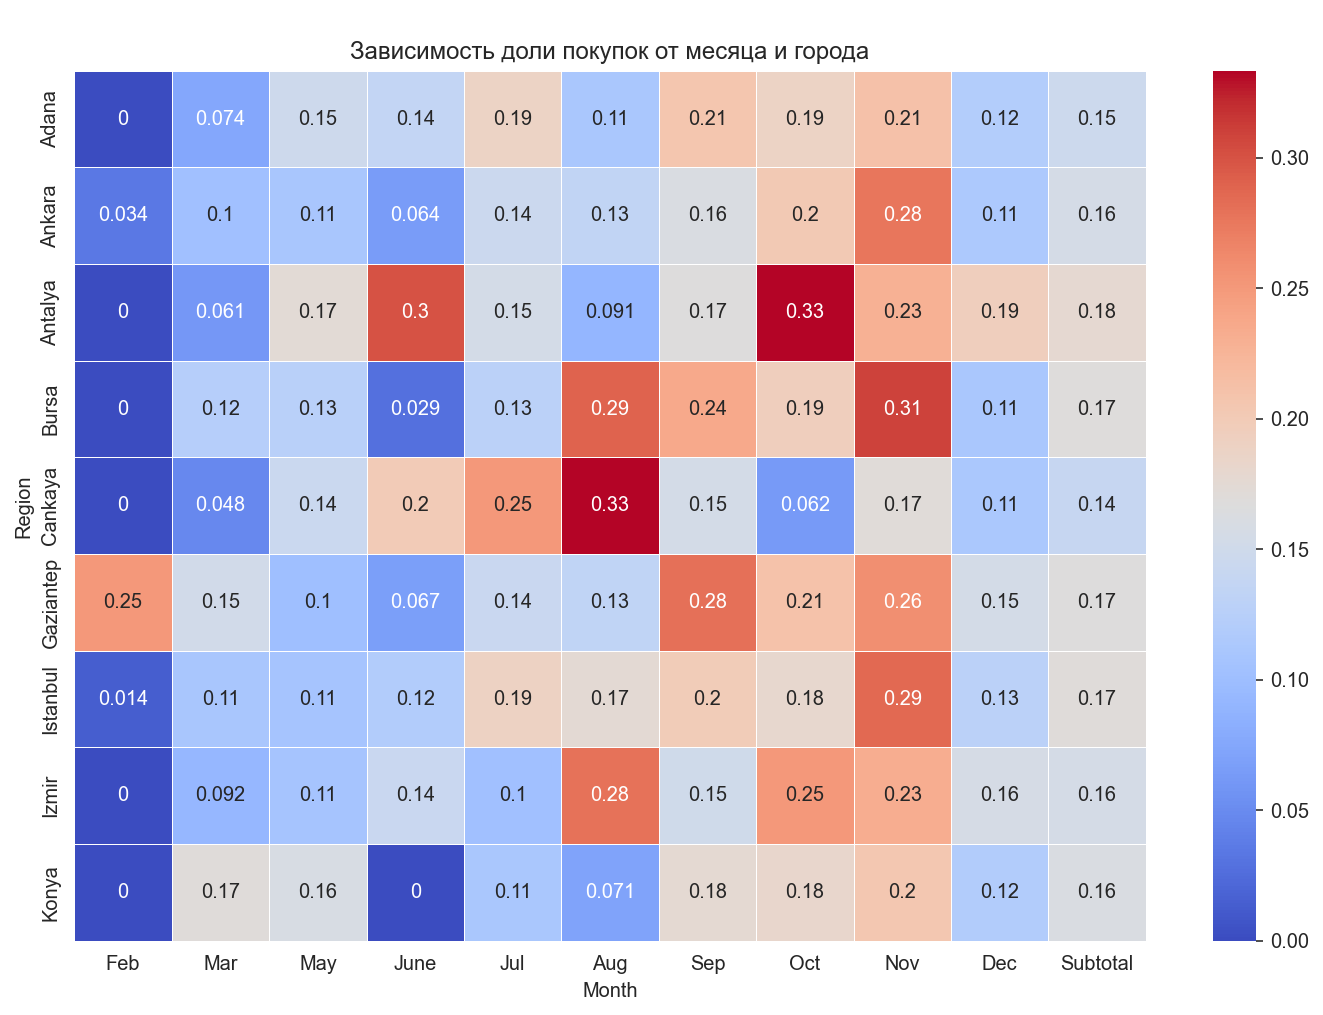

In [40]:
months = ['Feb', 'Mar', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plot_mean_target_map(df, ['Month', 'Region'], 'Revenue', months,
                     '\nЗависимость доли покупок от месяца и города')

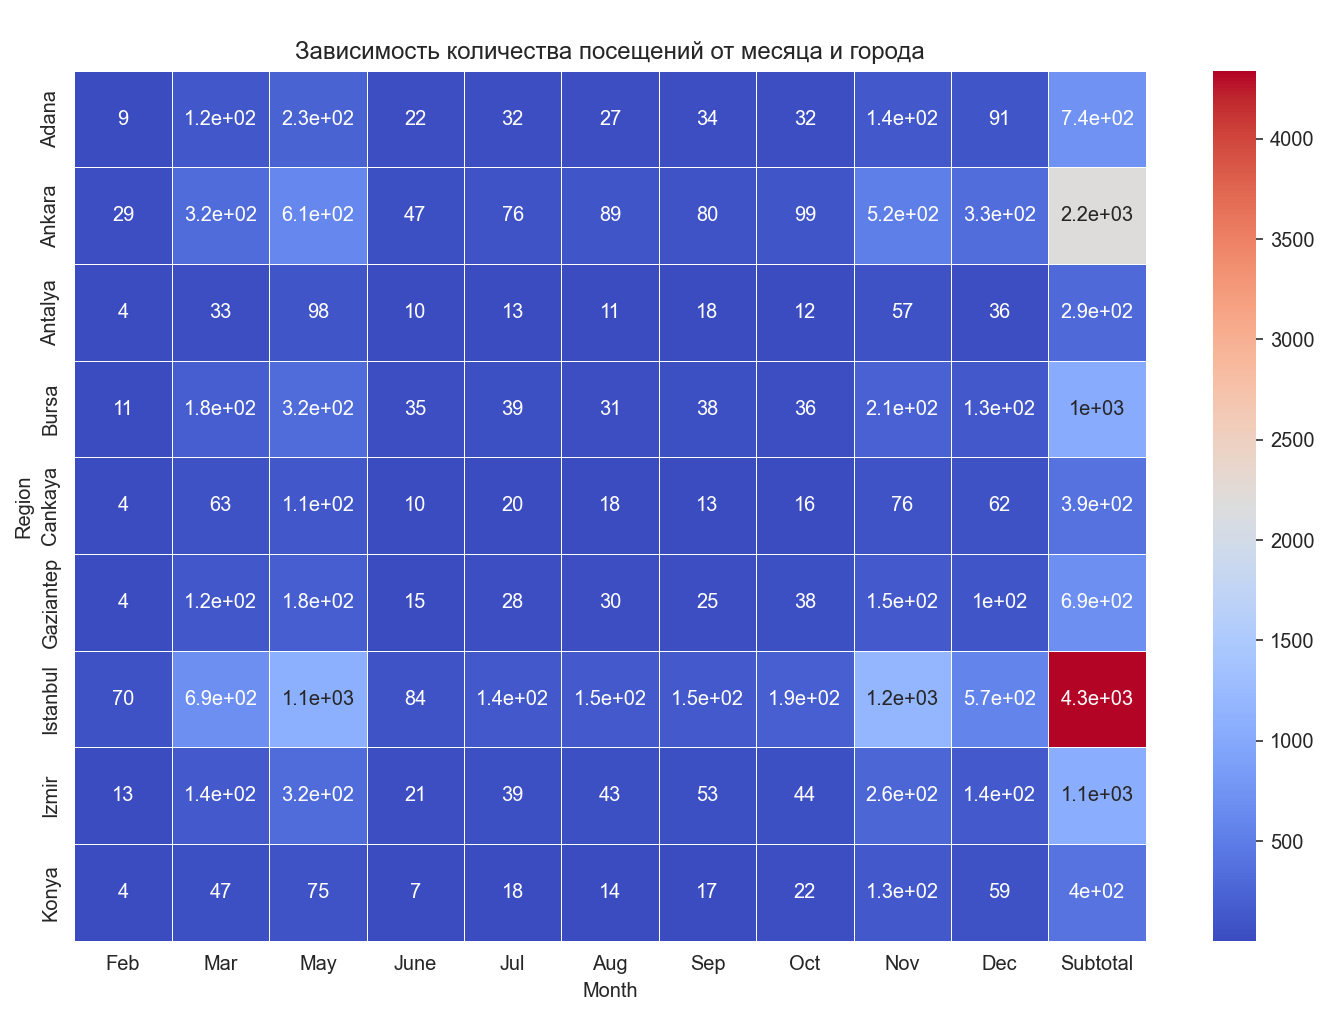

In [41]:
plot_count_target_map(df, ['Month', 'Region'], 'Revenue', months,
                      '\nЗависимость количества посещений от месяца и города')

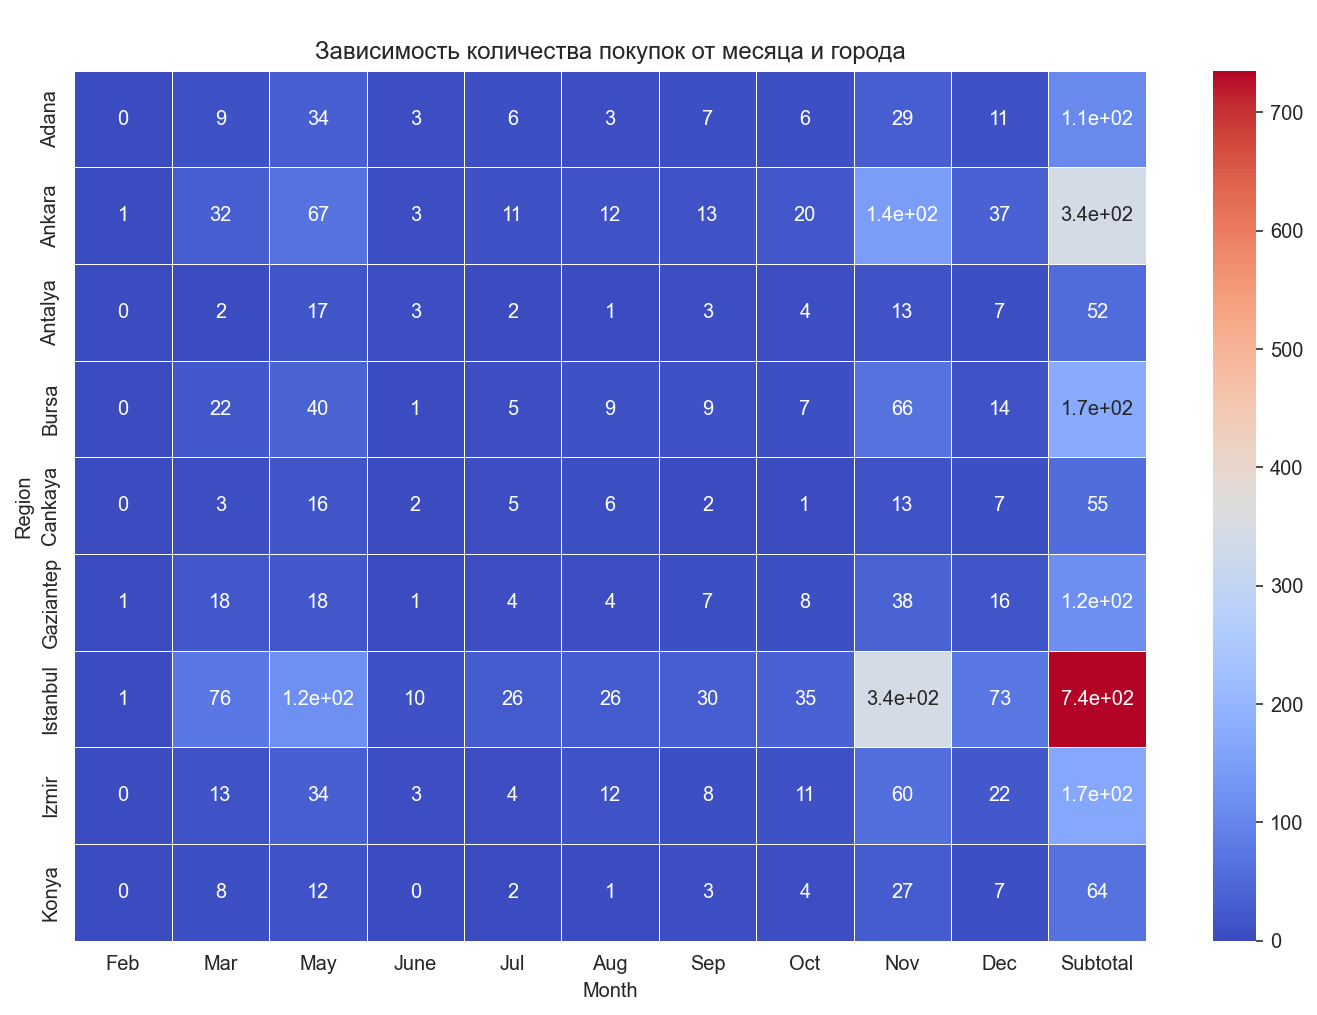

In [42]:
plot_sum_target_map(df, ['Month', 'Region'], 'Revenue', months,
                    '\nЗависимость количества покупок от месяца и города')

#### Тип трафика и пользователей

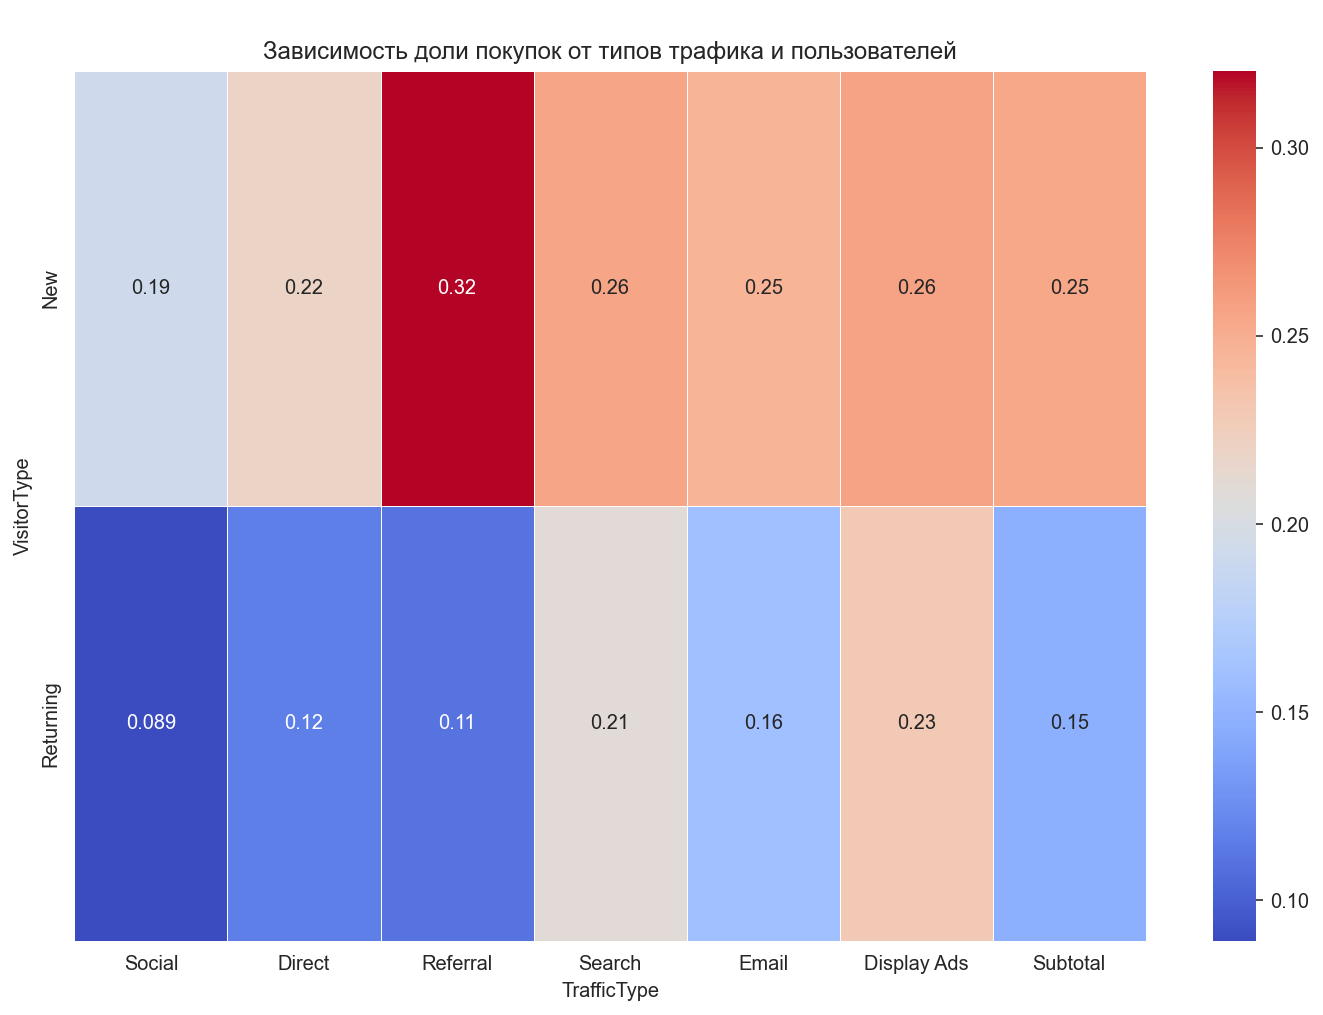

In [43]:
traffic_types = set(df['TrafficType'])

plot_mean_target_map(df, ['TrafficType', 'VisitorType'], 'Revenue', traffic_types,
                     '\nЗависимость доли покупок от типов трафика и пользователей')

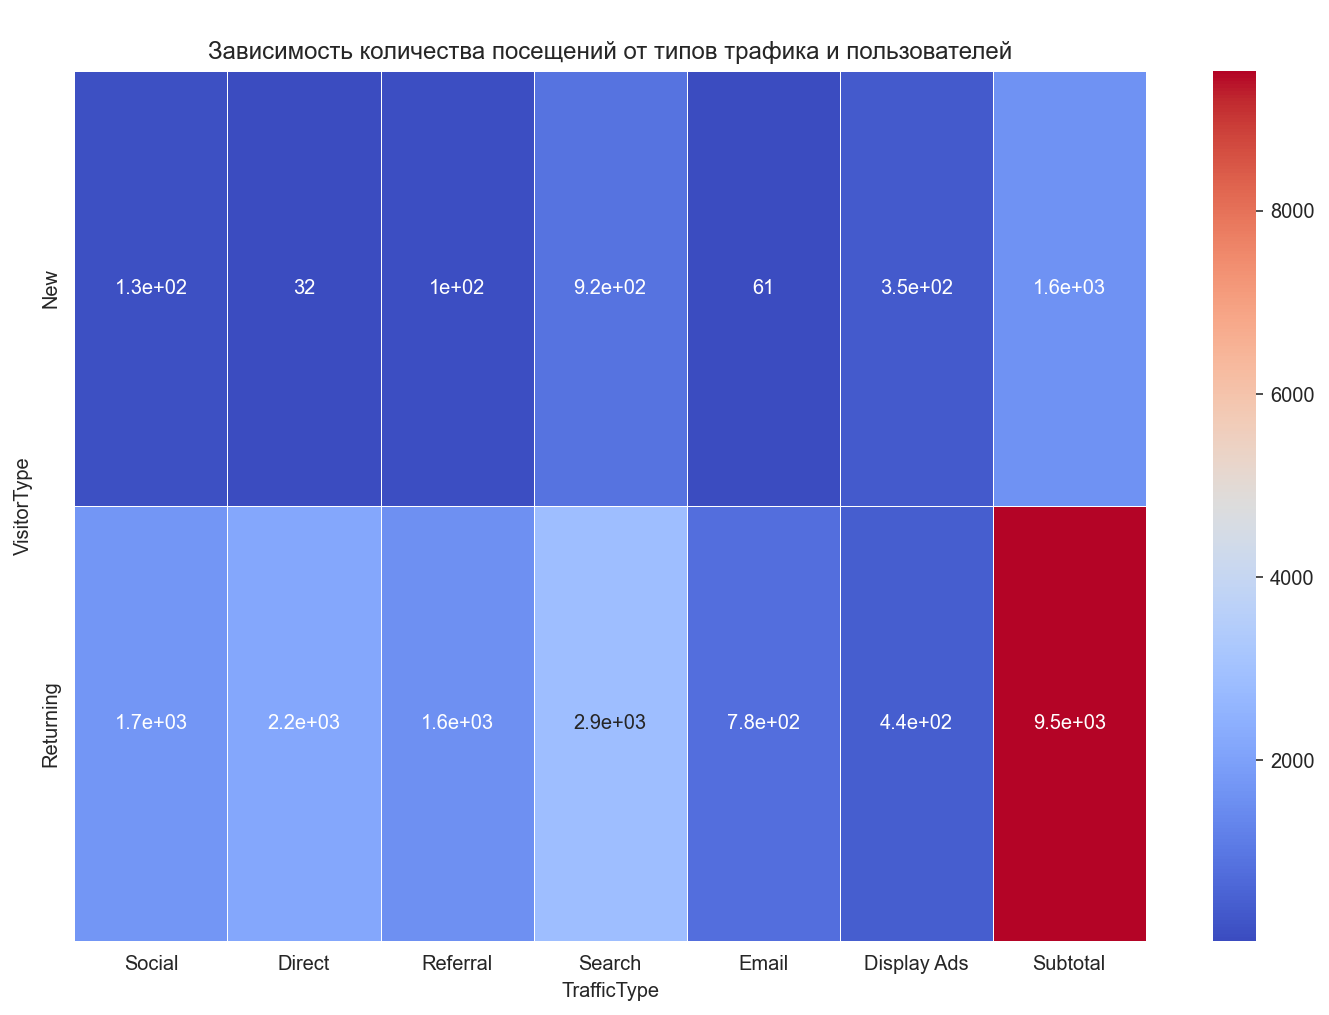

In [44]:
plot_count_target_map(df, ['TrafficType', 'VisitorType'], 'Revenue', traffic_types,
                      '\nЗависимость количества посещений от типов трафика и пользователей')

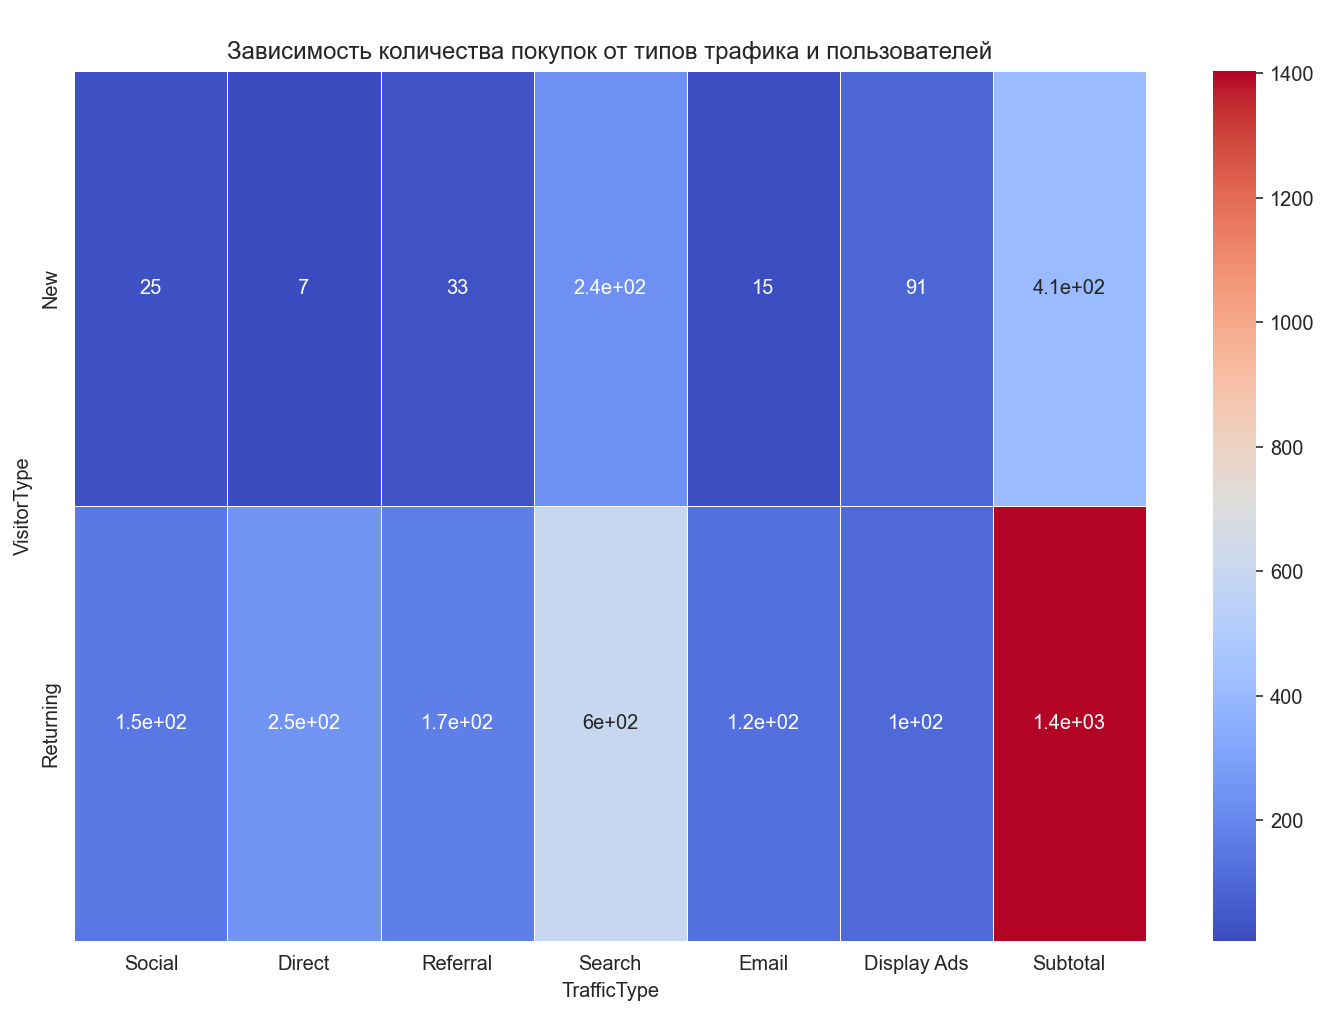

In [45]:
plot_sum_target_map(df, ['TrafficType', 'VisitorType'], 'Revenue', traffic_types,
                         '\nЗависимость количества покупок от типов трафика и пользователей')

#### Тип трафика и регион

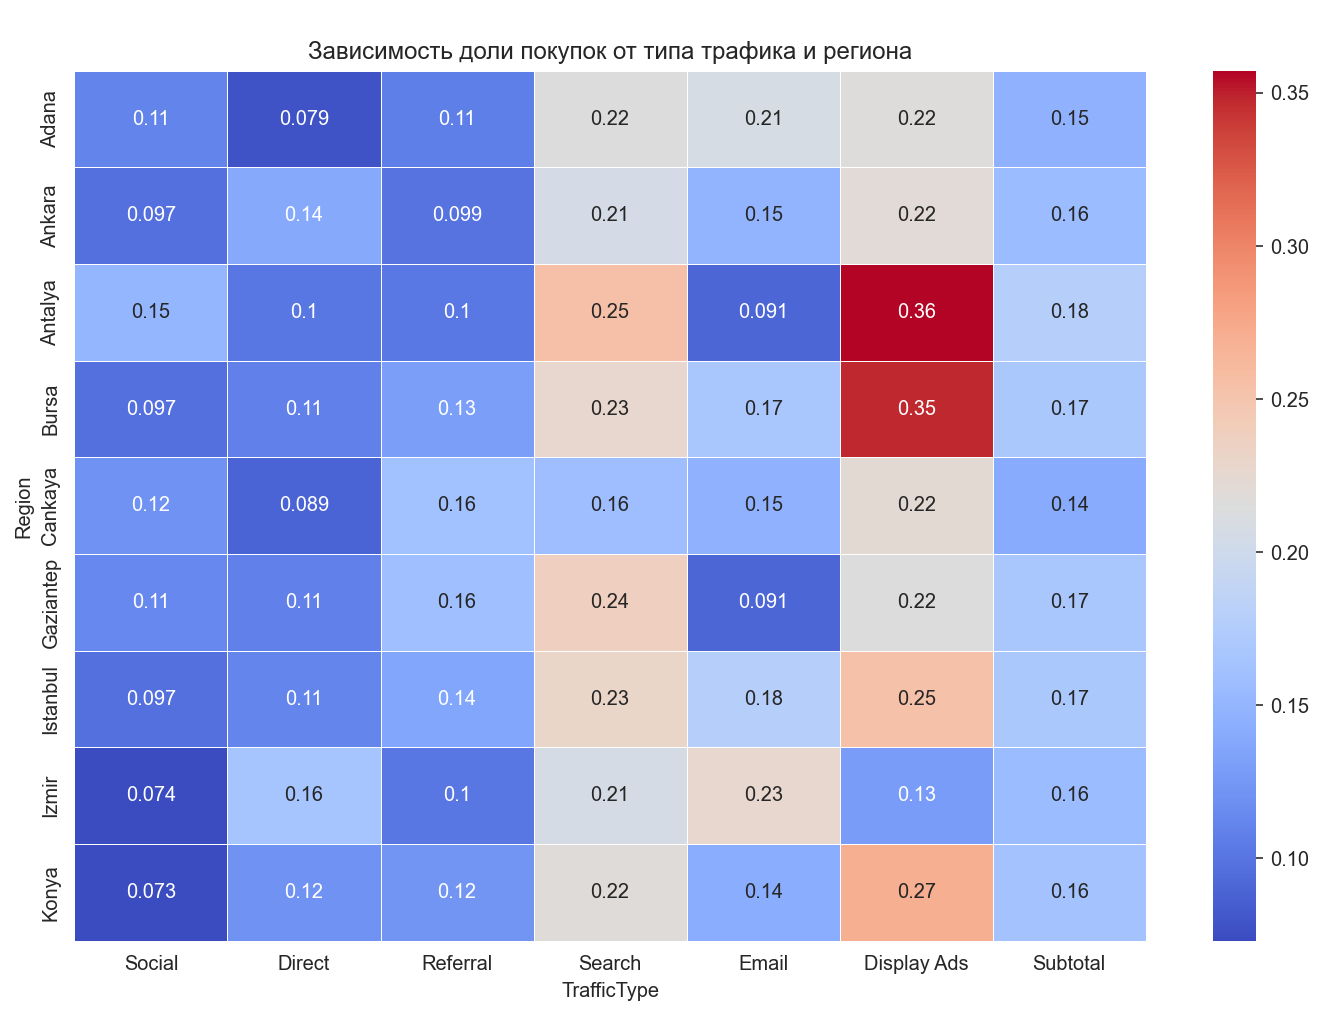

In [46]:
plot_mean_target_map(df, ['TrafficType', 'Region'], 'Revenue', traffic_types,
                     '\nЗависимость доли покупок от типа трафика и региона')

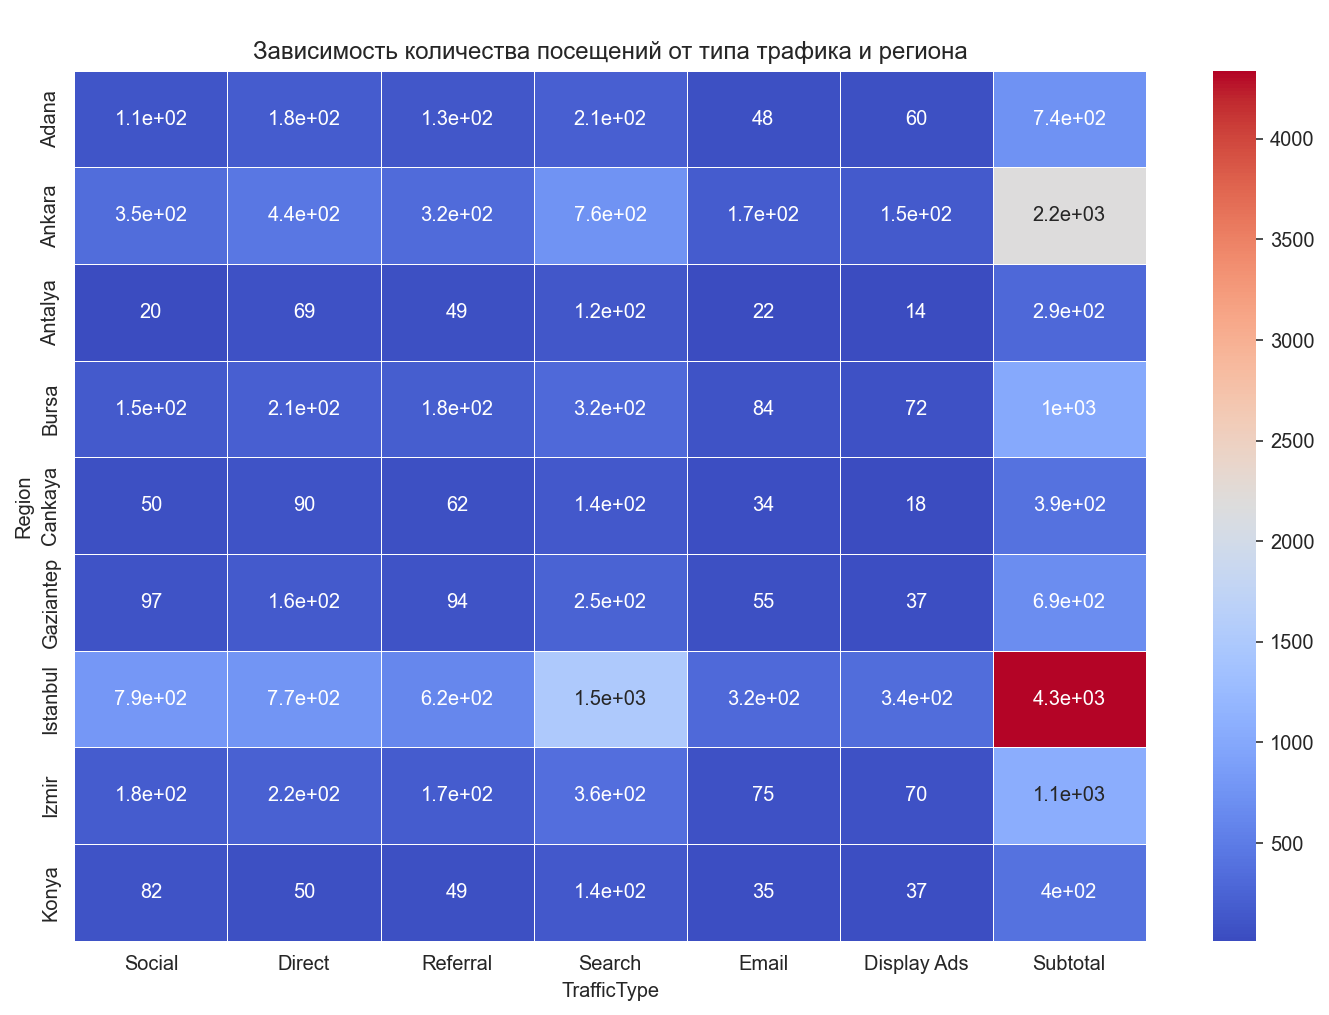

In [47]:
plot_count_target_map(df, ['TrafficType', 'Region'], 'Revenue', traffic_types,
                           '\nЗависимость количества посещений от типа трафика и региона')

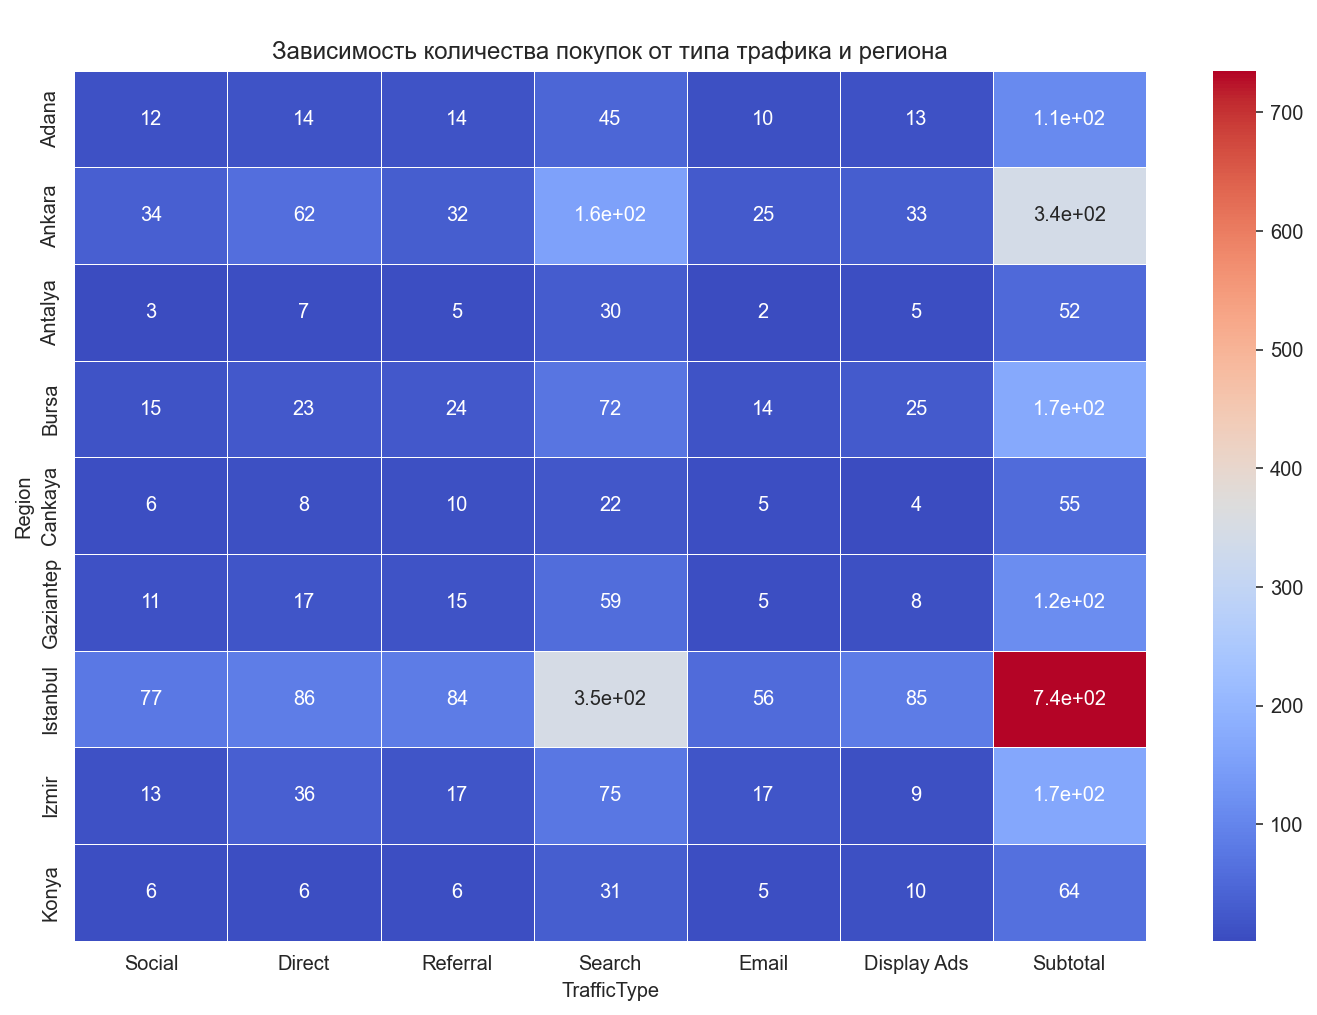

In [48]:
plot_sum_target_map(df, ['TrafficType', 'Region'], 'Revenue', traffic_types,
                         '\nЗависимость количества покупок от типа трафика и региона')

#### ОС и город

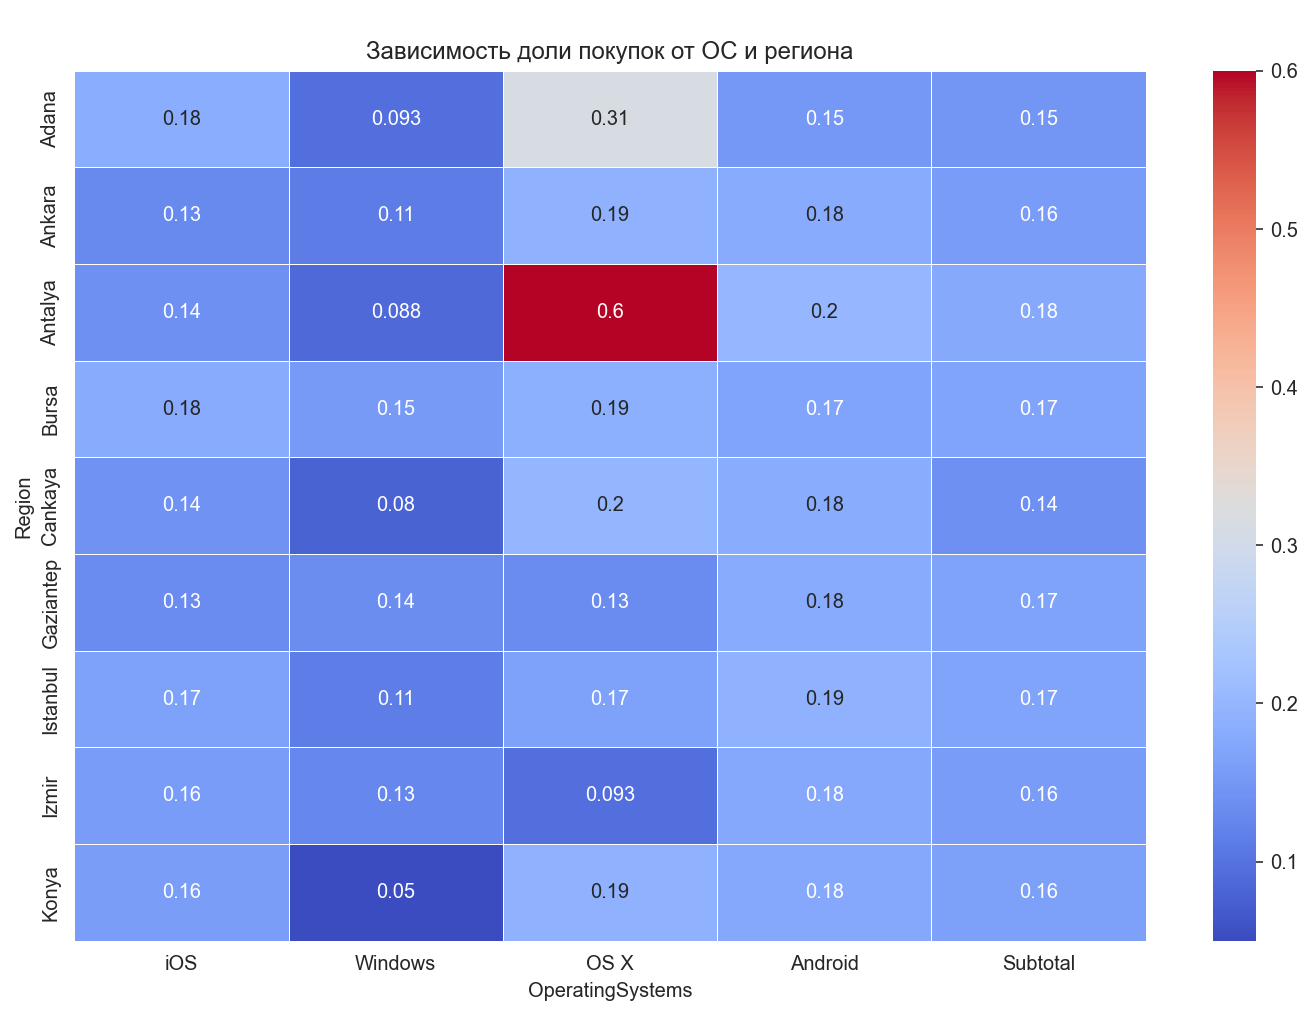

In [49]:
OS_types = set(df['OperatingSystems'])
plot_mean_target_map(df, ['OperatingSystems', 'Region'], 'Revenue', OS_types,
                     '\nЗависимость доли покупок от ОС и региона')

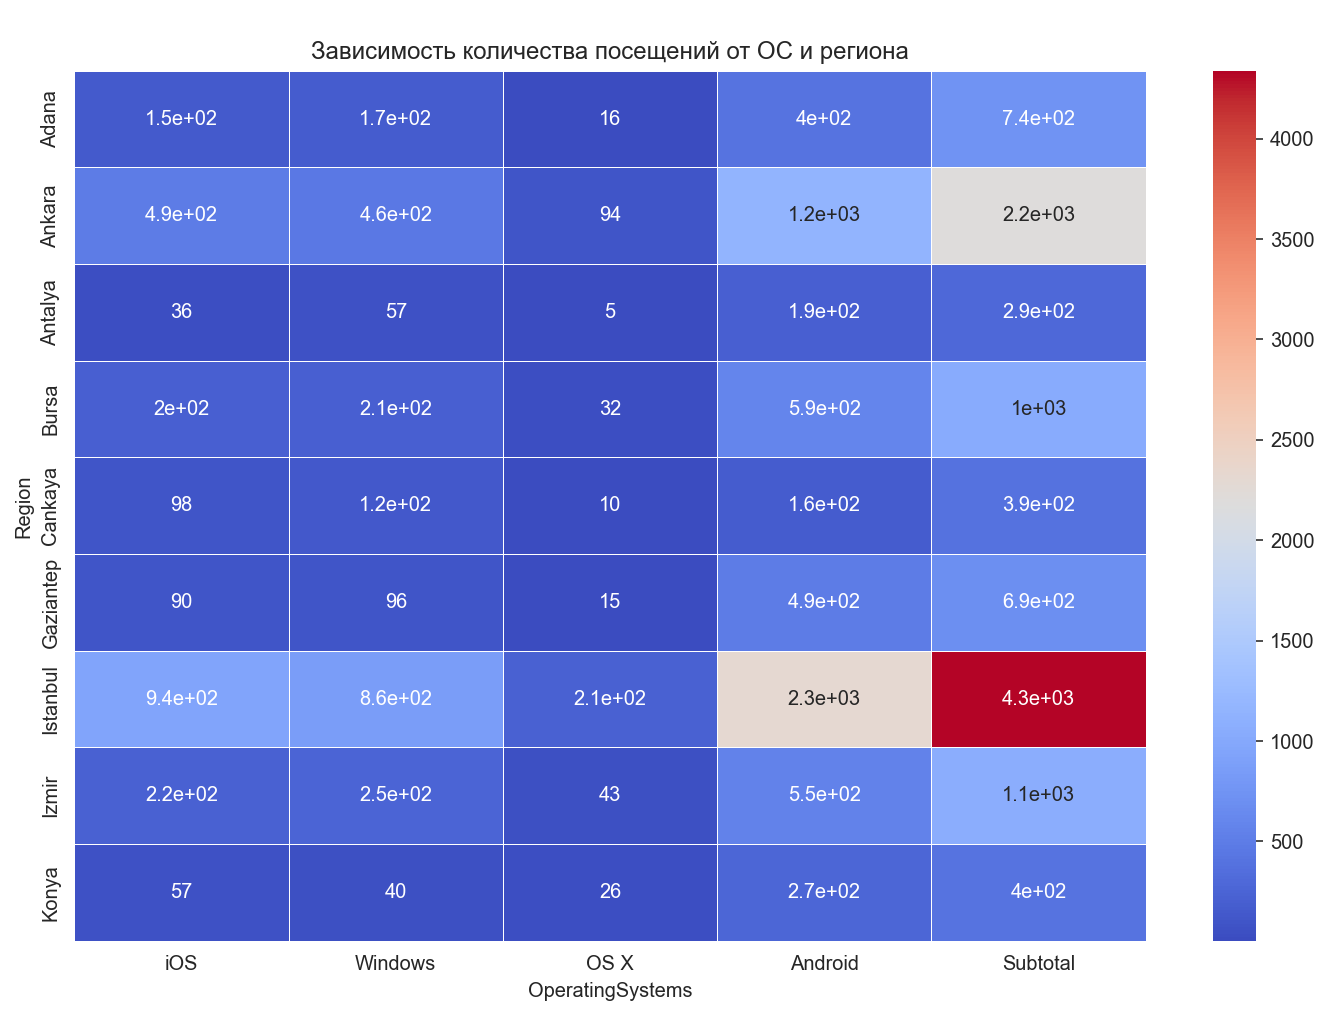

In [50]:
plot_count_target_map(df, ['OperatingSystems', 'Region'], 'Revenue', OS_types,
                     '\nЗависимость количества посещений от ОС и региона')

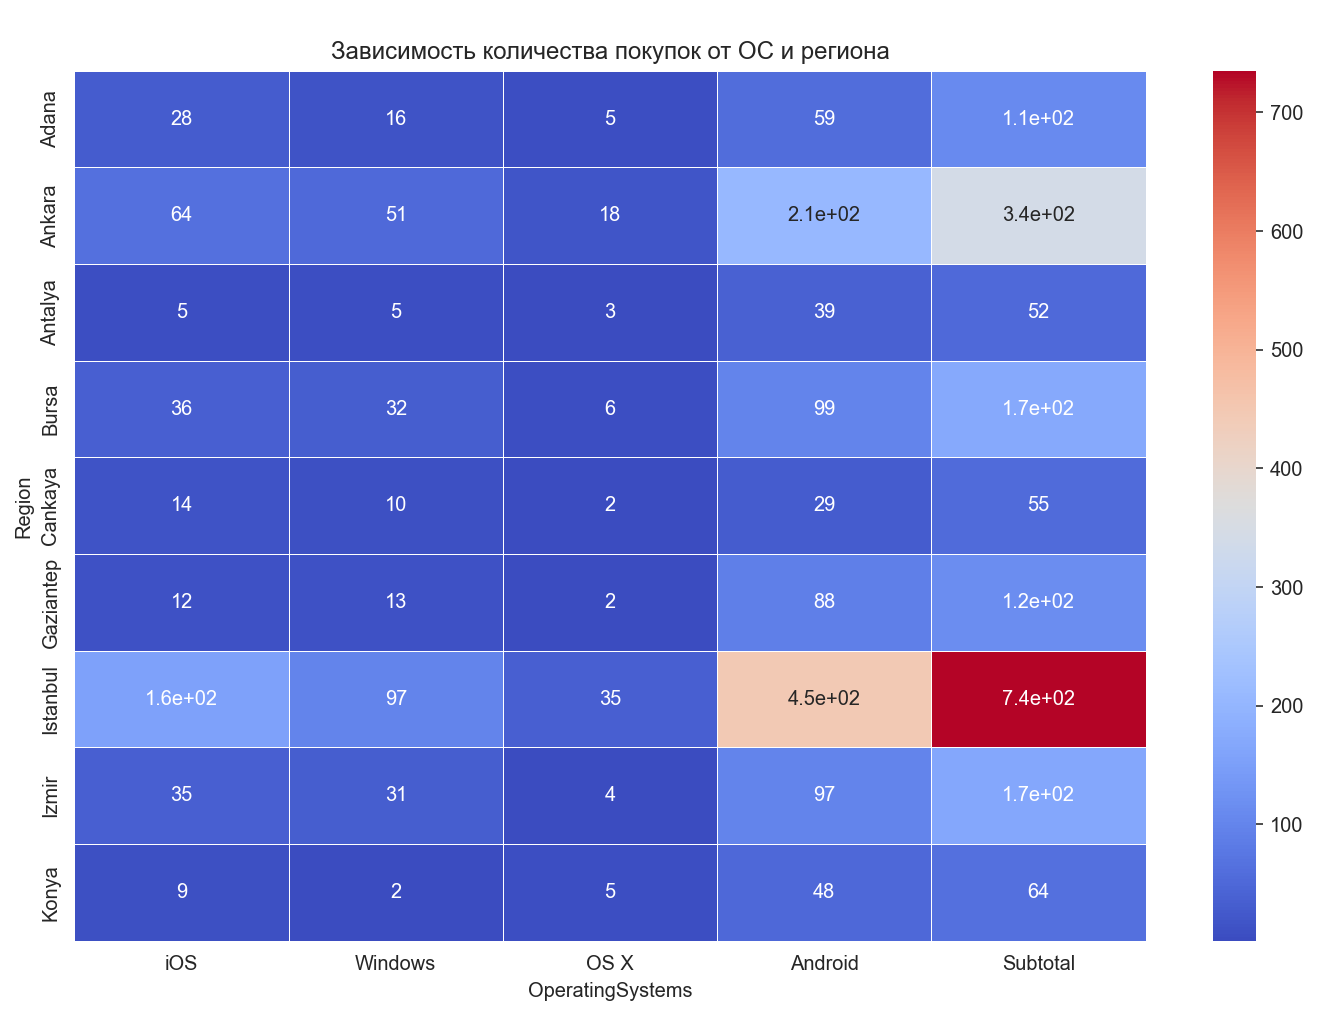

In [51]:
plot_sum_target_map(df, ['OperatingSystems', 'Region'], 'Revenue', OS_types,
                     '\nЗависимость количества покупок от ОС и региона')

# 5. Сегментация клиентов

## 5.1. K-means

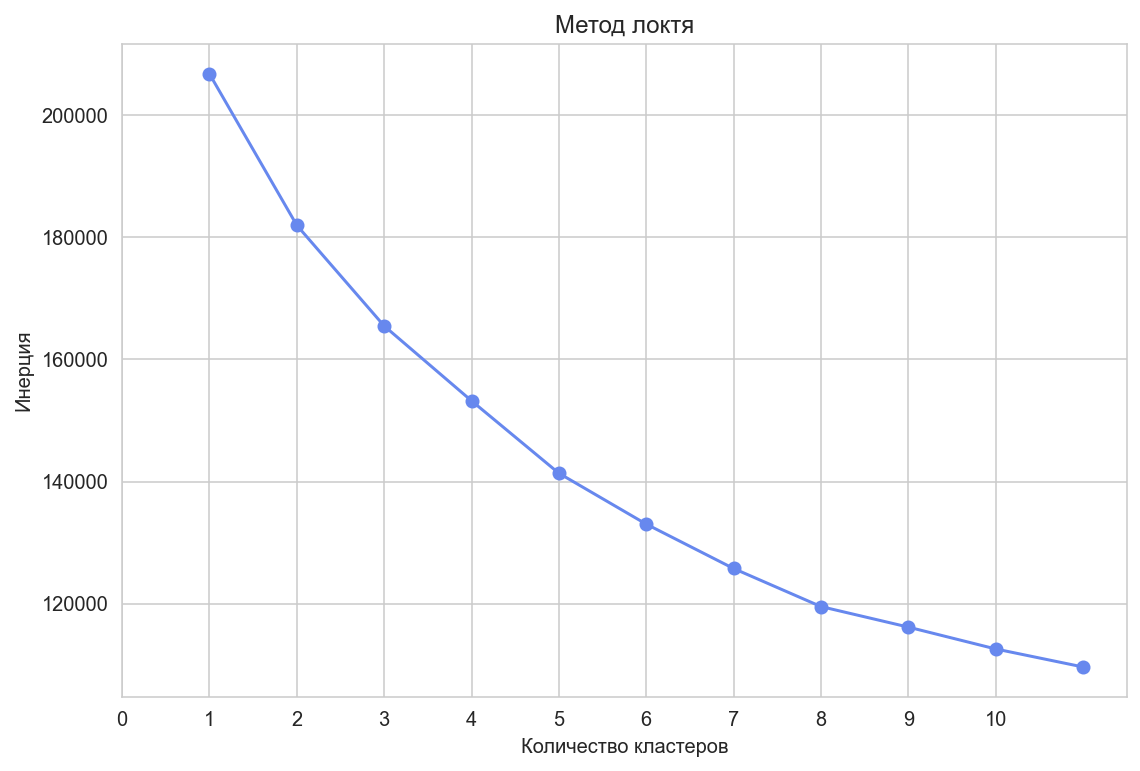

In [52]:
# выбор оптимального количества кластеров
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric),
    ('ohe', OneHotEncoder(), categ)
])

df_transf = column_transformer.fit_transform(df)

inertias = []
k_values = range(1, 12)

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_transf)
    inertias.append(kmeans.inertia_)

plt.figure(figsize = (9, 6))
plt.plot(k_values, inertias, '-o')
plt.xlabel('Количество кластеров')
plt.xticks(np.arange(max(k_values)))
plt.ylabel('Инерция')
plt.title('Метод локтя')
plt.show()

Предположительно, оптимальное количество кластеров - 4.

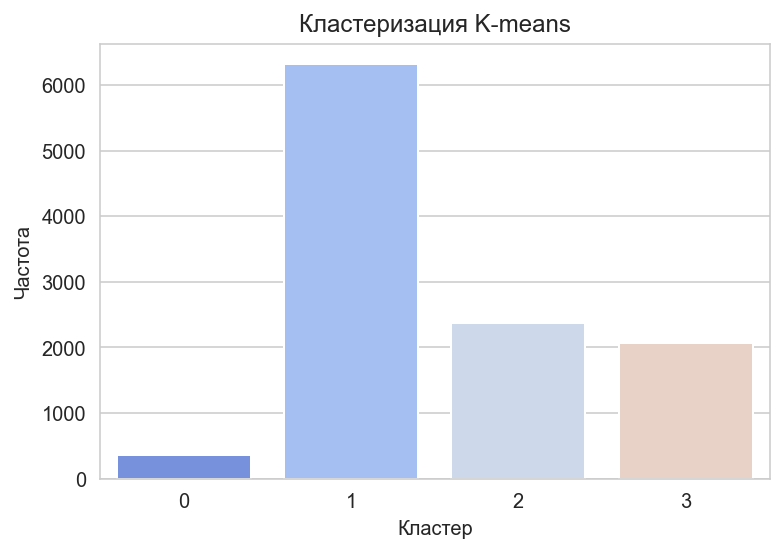

In [53]:
# кластеризация
pipeline_kmeans = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('clustering', KMeans(n_clusters=4, init='k-means++'))
])

cluster_kmeans = pipeline_kmeans.fit_predict(df)

# баланс классов
cp_kmeans = sns.countplot(cluster_kmeans)
cp_kmeans.set(title='Кластеризация K-means',
              xlabel='Кластер',
              ylabel='Частота')
plt.show()

Выделяется как слишком маленький, так и слишком большой по численности кластер. Это не стоит воспринимать как проблему: среди клиентов может быть как уникальный сегмент, так и массовый, который включает в себя множество однородных объектов, требующих одинакового подхода.

In [54]:
silhouette_score(df_transf, cluster_kmeans).round(2)

0.15

Значение метрики Silhouette для модели K-means близко к нулю, что означает, что кластеры довольно однородны и разница между ними не значима.

## 5.2. Иерархическая кластеризация

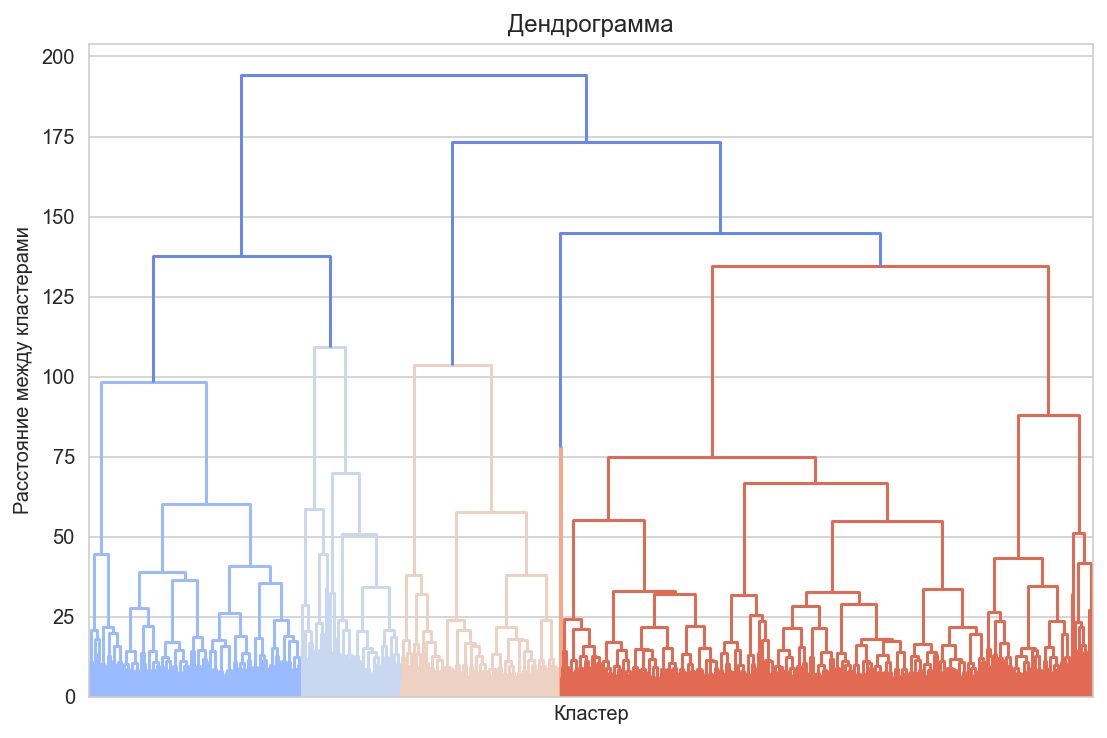

In [55]:
# дендрограмма
model_agg = AgglomerativeClustering(distance_threshold=0,
                                    n_clusters=None)
model_agg.fit(df_transf)

linkage_matrix = np.column_stack([model_agg.children_,
                                  model_agg.distances_,
                                  np.zeros(len(model_agg.children_))]).astype(float)


plt.figure(figsize = (9, 6))
dendrogram(linkage_matrix, no_labels=True)
plt.title('Дендрограмма')
plt.xlabel('Кластер')
plt.ylabel('Расстояние между кластерами')
plt.show()

Предположительно, оптимальное количество кластеров - 4.

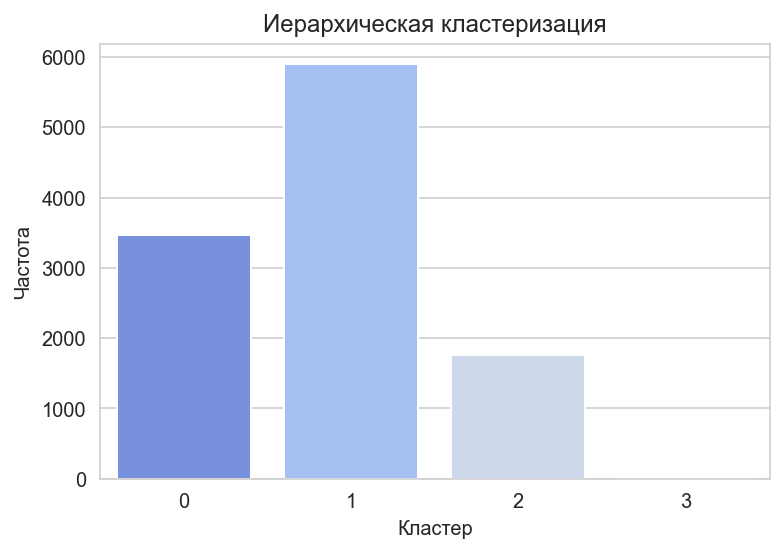

In [56]:
# кластеризация
pipeline_agg = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('clustering', AgglomerativeClustering(n_clusters=4))
])

cluster_agg = pipeline_agg.fit_predict(df)

# баланс классов
cp_agg = sns.countplot(cluster_agg)
cp_agg.set(title='Иерархическая кластеризация',
           xlabel='Кластер',
           ylabel='Частота')
plt.show()

Наблюдается сильный дисбаланс классов: в одном кластере практически нет наблюдений. Тем не менее, это может быть очень выделяющийся сегмент, как и в модели K-means.

In [57]:
silhouette_score(df_transf, cluster_agg).round(2)

0.1

Аналогично модели K-means, значение метрики Silhouette близко к нулю, значит сегменты довольно однородные.

## 5.3. Дерево решений

### Построение модели

In [58]:
# разбиение выборки на обучающую и тестовую
X = df_transf[:,:-1]
y = df_transf[:,-1]

objects = np.arange(len(df_transf))
train, test = train_test_split(objects,
                               test_size=0.3,
                               random_state=1719)

X_train = X[train]
y_train = y[train]
X_test = X[test]
y_test = y[test]

# кросс-валидация для определения оптимального набора параметров
cv = KFold(shuffle=True, random_state=1719)
gs = GridSearchCV(DecisionTreeClassifier(random_state=1719),
                  param_grid={
                      'max_features': ['auto', 'sqrt', 'log2'],
                      'max_depth': [2, 4, 6, 8, 10, 20, 50],
                      'min_samples_leaf': [1, 4, 8, 32, 64, 128],
                  },
                  cv=cv,
                  scoring='roc_auc')

gs.fit(X_train, y_train)

best_params = gs.best_params_
print(best_params)

{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 32}


In [59]:
# построение итогового классификатора
best_depth = best_params['max_depth']
best_features = best_params['max_features']
best_leaf = best_params['min_samples_leaf']

tree_clf = DecisionTreeClassifier(max_depth=best_depth,
                                  max_features=best_features,
                                  min_samples_leaf=best_leaf,
                                  random_state=1719)

tree_clf.fit(X_train, y_train)
preds_tree = tree_clf.predict_proba(X_test)[:,-1]

### Метрики качества
#### ROC AUC

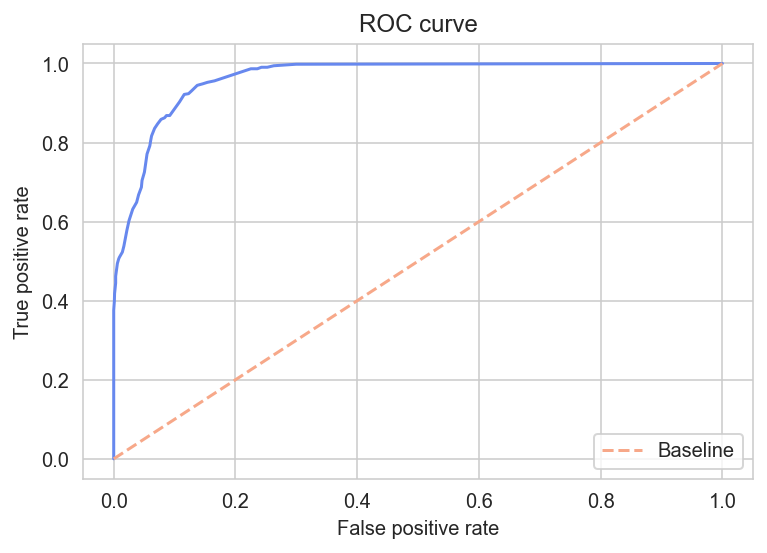

ROC AUC: 0.9638


In [60]:
fpr, tpr, thresholds = roc_curve(y_test, preds_tree)

plt.plot(fpr, tpr)
plt.plot([fpr.min(), fpr.max()],
         [tpr.min(), tpr.max()],
         label='Baseline',
         ls='--',
         c=palette[-2])
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

print(f'ROC AUC: {roc_auc_score(y_test, preds_tree).round(4)}')

#### F1

In [61]:
precision, recall, t = precision_recall_curve(y_test, preds_tree)
f_betas = (2 * precision * recall) / (precision + recall)
best_t = t[np.argmax(f_betas)]
print(f'F1: {f_betas.max().round(3)}')
print(f'Threshold: {best_t.round(3)}')

F1: 0.761
Threshold: 0.355


### Визуализации
#### Скоринг

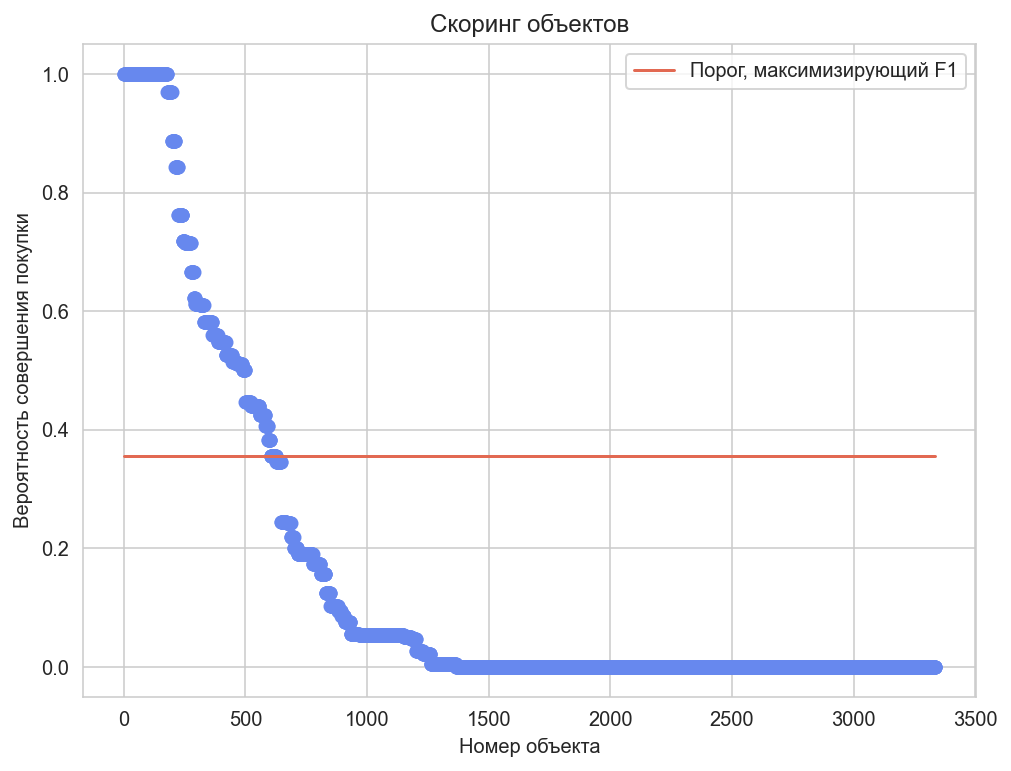

In [62]:
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(X_test.shape[0]), sorted(preds_tree)[::-1])

x_coords = [0, X_test.shape[0] - 1]
y_coords = [best_t] * 2
plt.plot(x_coords, y_coords, c=palette[-1], label='Порог, максимизирующий F1')

plt.title('Скоринг объектов')
plt.xlabel('Номер объекта')
plt.ylabel('Вероятность совершения покупки')
plt.legend()
plt.show()

#### Важность признаков

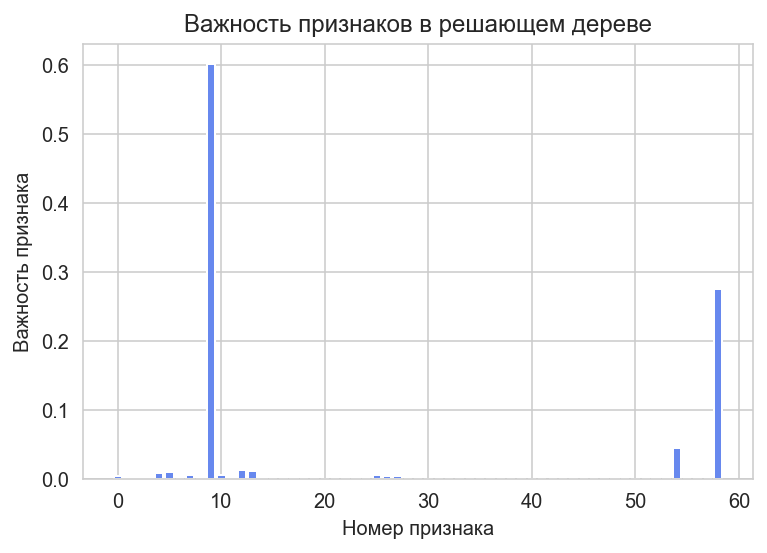

In [63]:
ft_imp = tree_clf.feature_importances_
ft_num = np.arange(X_test.shape[1])

plt.bar(ft_num, ft_imp)
plt.title('Важность признаков в решающем дереве')
plt.xlabel('Номер признака')
plt.ylabel('Важность признака')
plt.show()

In [64]:
first_best = sorted(ft_imp)[-1]
second_best = sorted(ft_imp)[-2]

# самые важные признаки
first_ind = np.where(ft_imp == first_best)[0] # PageValues_ProductRelated
second_ind = np.where(ft_imp == second_best)[0] # Weekend
print(first_ind, second_ind)
print(X_test.shape[1])

[9] [58]
59


#### Распределение целевой метки в листьях дерева

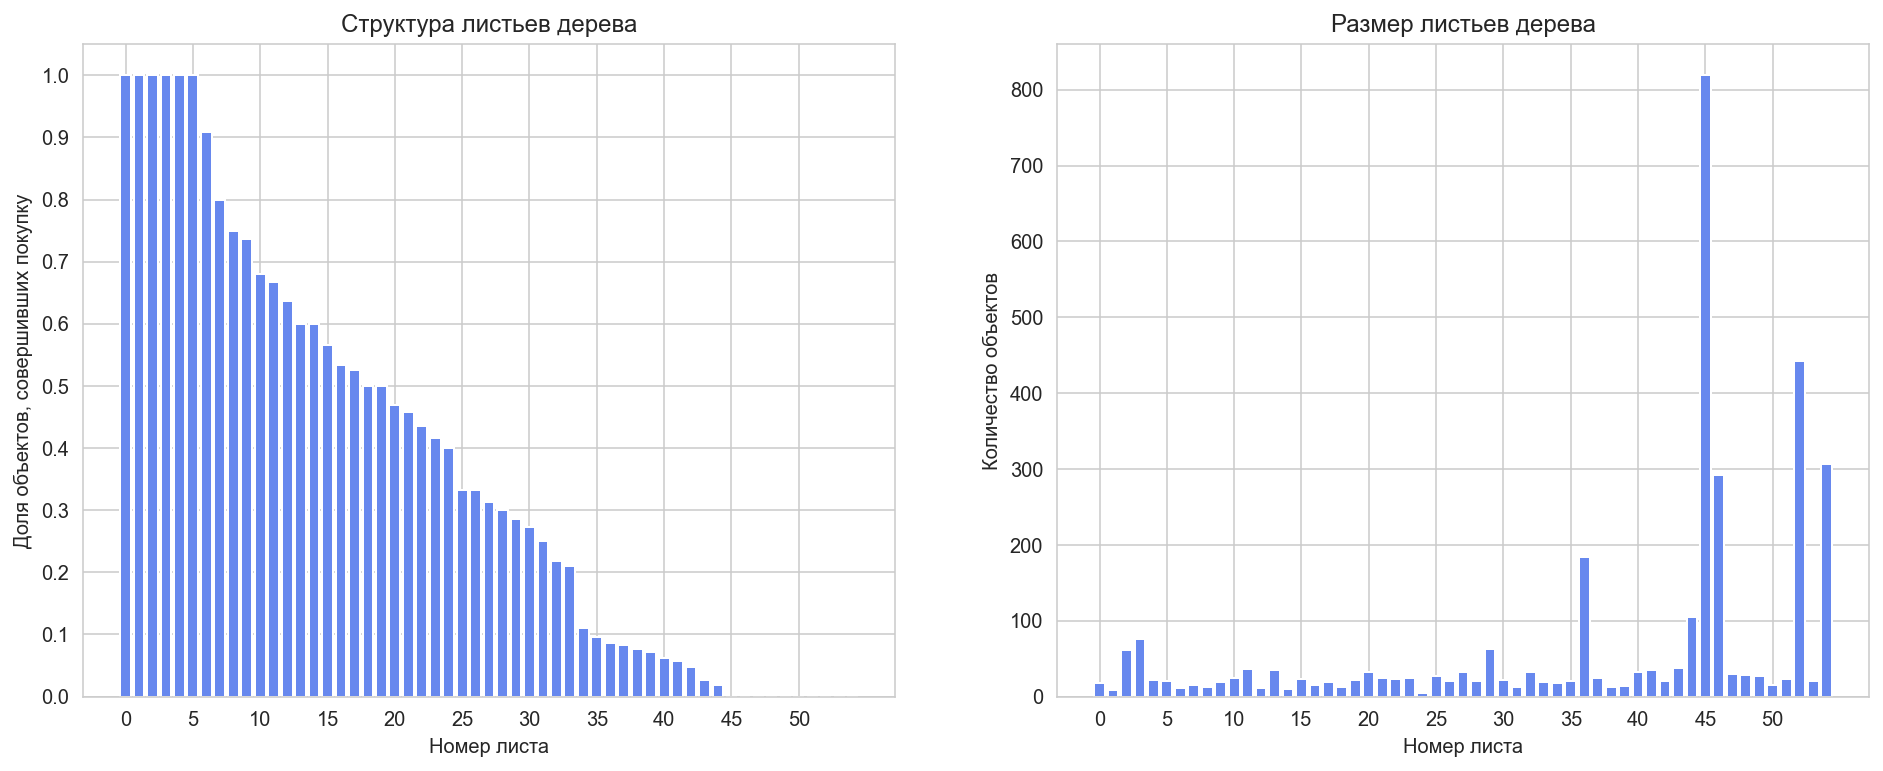

In [65]:
target = np.array(df.iloc[test]['Revenue'])

tree_describe = pd.DataFrame()
tree_describe['Object'] = test
tree_describe['Leaf'] = np.array(tree_clf.apply(X_test))
tree_describe['Target'] = target.astype(int)

agg_tree_describe = tree_describe.groupby(['Leaf']).agg({'Target': ['mean', 'count']})
agg_tree_describe.columns = agg_tree_describe.columns.get_level_values(1)
agg_tree_describe.sort_values(by='mean', ascending=False, inplace=True)

leaf_id = np.arange(len(agg_tree_describe))
plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.bar(leaf_id, agg_tree_describe['mean'])
plt.title('Структура листьев дерева')
plt.xticks(np.arange(0, leaf_id.max(), 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Номер листа')
plt.ylabel('Доля объектов, совершивших покупку')

plt.subplot(1, 2, 2)
plt.bar(leaf_id, agg_tree_describe['count'])
plt.title('Размер листьев дерева')
plt.xticks(np.arange(0, leaf_id.max(), 5))
plt.xlabel('Номер листа')
plt.ylabel('Количество объектов')

plt.show()

### Выделение сегментов

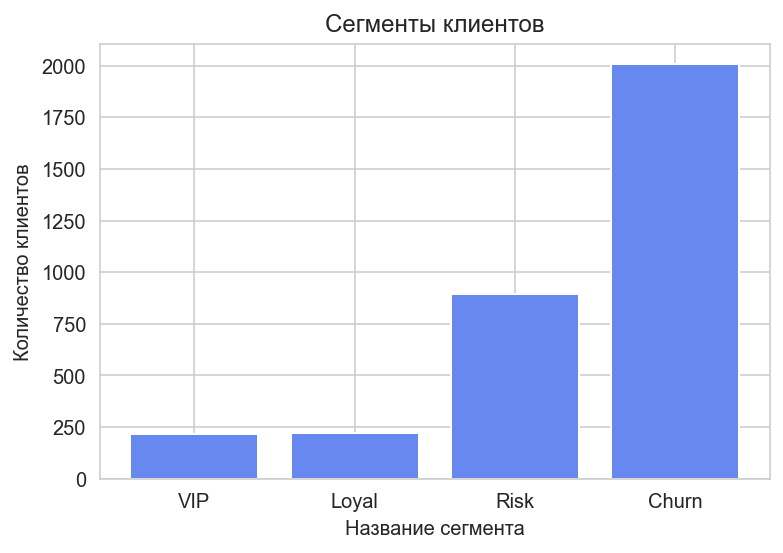

In [66]:
tree_describe.index = tree_describe['Leaf']

vip_leaves = agg_tree_describe[agg_tree_describe['mean'] > 0.8].index
vip_clients = list(tree_describe.loc[vip_leaves]['Object'])

loyal_leaves = agg_tree_describe[(agg_tree_describe['mean'] <= 0.8) &
                                 (agg_tree_describe['mean'] > 0.5)].index
loyal_clients = list(tree_describe.loc[loyal_leaves]['Object'])

risk_leaves = agg_tree_describe[(agg_tree_describe['mean'] <= 0.5) &
                                (agg_tree_describe['mean'] > 0)].index
risk_clients = list(tree_describe.loc[risk_leaves]['Object'])

churn_leaves = agg_tree_describe[agg_tree_describe['mean'] == 0].index
churn_clients = list(tree_describe.loc[churn_leaves]['Object'])

# визуализация сегментов
client_counts = [len(vip_clients), len(loyal_clients),
                 len(risk_clients), len(churn_clients)]
client_labels = ['VIP', 'Loyal', 'Risk', 'Churn']

plt.bar(client_labels, client_counts)
plt.title('Сегменты клиентов')
plt.xlabel('Название сегмента')
plt.ylabel('Количество клиентов')
plt.show()

При попытке описать сегменты было установлено, что они плохо различимы.

## 5.4. Бизнес-правила

### 1. Стамбул + Анкара + IOS 

In [67]:
segment_1_df = df[df.Region.isin(['Istanbul', 'Ankara']) & (df.OperatingSystems == 'iOS')]
np.round(segment_1_df.describe(), 2).T

count   mean     std   min   25%    50%  \
Administrative                     1431.0   2.53    3.34  0.00  0.00   1.00   
Administrative_Duration            1431.0  94.63  177.27  0.00  0.00  23.20   
Informational                      1431.0   0.60    1.33  0.00  0.00   0.00   
Informational_Duration             1431.0  36.21  135.15  0.00  0.00   0.00   
LogProductRelated                  1431.0   2.88    0.97  0.69  2.20   2.89   
LogProductRelated_Duration         1431.0   6.18    1.34  1.79  5.39   6.29   
ProductRelatedPrc                  1431.0   0.89    0.14  0.20  0.83   0.94   
ProductRelated_Duration_Prc        1431.0   0.88    0.18  0.03  0.81   0.96   
LogAv_ProductRelated_Duration      1431.0   3.43    0.67  0.98  3.02   3.40   
PageValues_ProductRelated          1431.0   0.33    1.93  0.00  0.00   0.00   
PageValues_ProductRelatedDuration  1431.0   0.01    0.07  0.00  0.00   0.00   
BounceRates                        1431.0   0.01    0.02  0.00  0.00   0.00   
LogExitRates                       1431.0   0.03    0.03  0.00  0.01   0.02   
PageValues                         1431.0   5.42   16.68  0.00  0.00   0.00   
SpecialDay                         1431.0   0.05    0.18  0.00  0.00   0.00   

                                      75%      max  
Administrative                       4.00    20.00  
Administrative_Duration            123.62  1715.00  
Informational                        0.00    12.00  
Informational_Duration               0.00  2195.30  
LogProductRelated                    3.53     6.25  
LogProductRelated_Duration           7.14    10.20  
ProductRelatedPrc                    1.00     1.00  
ProductRelated_Duration_Prc          1.00     1.00  
LogAv_ProductRelated_Duration        3.80     6.42  
PageValues_ProductRelated            0.00    56.21  
PageValues_ProductRelatedDuration    0.00     1.98  
BounceRates                          0.01     0.17  
LogExitRates                         0.04     0.16  
PageValues                           0.00   218.40  
SpecialDay                           0.00     1.00

In [68]:
segment_1_df[['Month', 'TrafficType', 'VisitorType', 'Revenue']].mode()

Month TrafficType VisitorType  Revenue
0   Nov      Search   Returning    False

In [98]:
winter_1 = segment_1_df.Month.isin(['Nov', 'Oct', 'Sep', 'Dec', 'Feb']).mean()
summer_1 = 1 - winter_1

print('Winter rate: %.2f' % winter_1)
print('Summer rate: %.2f' % summer_1)

Winter rate: 0.54
Summer rate: 0.46


In [69]:
np.round(segment_1_df['Revenue'].mean() * 100, 2) # доля покупок

15.37

In [70]:
np.round((segment_1_df['VisitorType']=='Returning').mean() * 100, 2) # доля вернувшихся

83.02

In [71]:
segment_1_df[segment_1_df['TrafficType'] != 'Search']['TrafficType'].mode().loc[0]

'Social'

### 2. Стамбул + Анкара + Android

In [72]:
segment_2_df = df[df.Region.isin(['Istanbul', 'Ankara']) & (df.OperatingSystems == 'Android')]
np.round(segment_2_df.describe(), 2).T

count   mean     std   min   25%    50%  \
Administrative                     3473.0   2.48    3.48  0.00  0.00   1.00   
Administrative_Duration            3473.0  81.66  194.83  0.00  0.00  13.10   
Informational                      3473.0   0.56    1.33  0.00  0.00   0.00   
Informational_Duration             3473.0  42.99  168.15  0.00  0.00   0.00   
LogProductRelated                  3473.0   3.17    1.06  0.69  2.40   3.18   
LogProductRelated_Duration         3473.0   6.51    1.47  0.69  5.63   6.67   
ProductRelatedPrc                  3473.0   0.91    0.12  0.20  0.88   0.96   
ProductRelated_Duration_Prc        3473.0   0.92    0.15  0.02  0.90   0.98   
LogAv_ProductRelated_Duration      3473.0   3.45    0.72  0.29  3.00   3.45   
PageValues_ProductRelated          3473.0   0.38    1.93  0.00  0.00   0.00   
PageValues_ProductRelatedDuration  3473.0   0.01    0.07  0.00  0.00   0.00   
BounceRates                        3473.0   0.01    0.02  0.00  0.00   0.00   
LogExitRates                       3473.0   0.03    0.03  0.00  0.01   0.02   
PageValues                         3473.0   7.13   21.01  0.00  0.00   0.00   
SpecialDay                         3473.0   0.06    0.20  0.00  0.00   0.00   

                                     75%      max  
Administrative                      4.00    27.00  
Administrative_Duration            83.00  3398.75  
Informational                       0.00    16.00  
Informational_Duration              0.00  2549.38  
LogProductRelated                   3.87     6.53  
LogProductRelated_Duration          7.53    11.07  
ProductRelatedPrc                   1.00     1.00  
ProductRelated_Duration_Prc         1.00     1.00  
LogAv_ProductRelated_Duration       3.88     7.25  
PageValues_ProductRelated           0.01    56.96  
PageValues_ProductRelatedDuration   0.00     2.49  
BounceRates                         0.01     0.18  
LogExitRates                        0.04     0.17  
PageValues                          1.80   361.76  
SpecialDay                          0.00     1.00

In [73]:
segment_2_df[['Month', 'TrafficType', 'VisitorType', 'Revenue']].mode()

Month TrafficType VisitorType  Revenue
0   May      Search   Returning    False

In [99]:
winter_2 = segment_2_df.Month.isin(['Nov', 'Oct', 'Sep', 'Dec', 'Feb']).mean()
summer_2 = 1 - winter_2

print('Winter rate: %.2f' % winter_2)
print('Summer rate: %.2f' % summer_2)

Winter rate: 0.48
Summer rate: 0.52


In [74]:
np.round(segment_2_df['Revenue'].mean() * 100, 2) # доля покупок

18.86

In [75]:
np.round((segment_2_df['VisitorType']=='Returning').mean() * 100, 2) # доля вернувшихся

85.75

In [76]:
segment_2_df[segment_2_df['TrafficType'] != 'Search']['TrafficType'].mode().loc[0]

'Direct'

### 3. Остальные города + IOS

In [77]:
segment_3_df = df[~df.Region.isin(['Istanbul', 'Ankara']) & (df.OperatingSystems == 'iOS')]
np.round(segment_3_df.describe(), 2).T

count   mean     std   min   25%    50%  \
Administrative                     857.0   2.27    2.98  0.00  0.00   1.00   
Administrative_Duration            857.0  91.46  178.60  0.00  0.00  27.33   
Informational                      857.0   0.44    1.14  0.00  0.00   0.00   
Informational_Duration             857.0  30.28  126.35  0.00  0.00   0.00   
LogProductRelated                  857.0   2.78    0.89  0.69  2.08   2.77   
LogProductRelated_Duration         857.0   6.11    1.26  2.40  5.33   6.21   
ProductRelatedPrc                  857.0   0.89    0.14  0.29  0.82   0.94   
ProductRelated_Duration_Prc        857.0   0.87    0.19  0.05  0.80   0.96   
LogAv_ProductRelated_Duration      857.0   3.46    0.65  1.73  3.04   3.44   
PageValues_ProductRelated          857.0   0.43    2.18  0.00  0.00   0.00   
PageValues_ProductRelatedDuration  857.0   0.01    0.12  0.00  0.00   0.00   
BounceRates                        857.0   0.01    0.02  0.00  0.00   0.00   
LogExitRates                       857.0   0.03    0.03  0.00  0.01   0.02   
PageValues                         857.0   5.92   18.36  0.00  0.00   0.00   
SpecialDay                         857.0   0.04    0.17  0.00  0.00   0.00   

                                      75%      max  
Administrative                       4.00    17.00  
Administrative_Duration            115.00  2156.17  
Informational                        0.00    10.00  
Informational_Duration               0.00  1657.30  
LogProductRelated                    3.43     5.04  
LogProductRelated_Duration           7.05     9.15  
ProductRelatedPrc                    1.00     1.00  
ProductRelated_Duration_Prc          1.00     1.00  
LogAv_ProductRelated_Duration        3.85     6.48  
PageValues_ProductRelated            0.00    47.79  
PageValues_ProductRelatedDuration    0.00     3.06  
BounceRates                          0.02     0.17  
LogExitRates                         0.04     0.17  
PageValues                           0.00   218.86  
SpecialDay                           0.00     1.00

In [78]:
segment_3_df[['Month', 'TrafficType', 'VisitorType', 'Revenue']].mode()

Month TrafficType VisitorType  Revenue
0   Nov      Search   Returning    False

In [100]:
winter_3 = segment_3_df.Month.isin(['Nov', 'Oct', 'Sep', 'Dec', 'Feb']).mean()
summer_3 = 1 - winter_3

print('Winter rate: %.2f' % winter_3)
print('Summer rate: %.2f' % summer_3)

Winter rate: 0.52
Summer rate: 0.48


In [79]:
np.round(segment_3_df['Revenue'].mean() * 100, 2) # доля покупок

16.22

In [80]:
np.round((segment_3_df['VisitorType']=='Returning').mean() * 100, 2) # доля вернувшихся

83.9

In [81]:
segment_3_df[segment_3_df['TrafficType'] != 'Search']['TrafficType'].mode().loc[0]

'Social'

### 4. Остальные города + Android

In [82]:
segment_4_df = df[~df.Region.isin(['Istanbul', 'Ankara']) & (df.OperatingSystems == 'Android')]
np.round(segment_4_df.describe(), 2).T

count   mean     std   min   25%    50%  \
Administrative                     2648.0   2.45    3.33  0.00  0.00   1.00   
Administrative_Duration            2648.0  77.81  157.72  0.00  0.00  16.10   
Informational                      2648.0   0.48    1.21  0.00  0.00   0.00   
Informational_Duration             2648.0  32.88  127.77  0.00  0.00   0.00   
LogProductRelated                  2648.0   3.11    1.00  0.69  2.40   3.14   
LogProductRelated_Duration         2648.0   6.45    1.43  0.41  5.63   6.66   
ProductRelatedPrc                  2648.0   0.91    0.13  0.17  0.87   0.96   
ProductRelated_Duration_Prc        2648.0   0.91    0.15  0.04  0.89   0.98   
LogAv_ProductRelated_Duration      2648.0   3.45    0.73  0.26  3.01   3.44   
PageValues_ProductRelated          2648.0   0.37    1.73  0.00  0.00   0.00   
PageValues_ProductRelatedDuration  2648.0   0.01    0.15  0.00  0.00   0.00   
BounceRates                        2648.0   0.01    0.02  0.00  0.00   0.00   
LogExitRates                       2648.0   0.03    0.03  0.00  0.01   0.02   
PageValues                         2648.0   7.01   19.19  0.00  0.00   0.00   
SpecialDay                         2648.0   0.07    0.21  0.00  0.00   0.00   

                                     75%      max  
Administrative                      4.00    24.00  
Administrative_Duration            90.53  1946.00  
Informational                       0.00    12.00  
Informational_Duration              0.00  1779.17  
LogProductRelated                   3.78     6.06  
LogProductRelated_Duration          7.44    10.08  
ProductRelatedPrc                   1.00     1.00  
ProductRelated_Duration_Prc         1.00     1.00  
LogAv_ProductRelated_Duration       3.89     7.09  
PageValues_ProductRelated           0.02    37.77  
PageValues_ProductRelatedDuration   0.00     6.95  
BounceRates                         0.01     0.16  
LogExitRates                        0.04     0.17  
PageValues                          1.61   239.98  
SpecialDay                          0.00     1.00

In [83]:
segment_4_df[['Month', 'TrafficType', 'VisitorType', 'Revenue']].mode()

Month TrafficType VisitorType  Revenue
0   May      Search   Returning    False

In [101]:
winter_4 = segment_4_df.Month.isin(['Nov', 'Oct', 'Sep', 'Dec', 'Feb']).mean()
summer_4 = 1 - winter_4

print('Winter rate: %.2f' % winter_4)
print('Summer rate: %.2f' % summer_4)

Winter rate: 0.43
Summer rate: 0.57


In [84]:
np.round(segment_4_df['Revenue'].mean() * 100, 2) # доля покупок

17.33

In [85]:
np.round((segment_4_df['VisitorType']=='Returning').mean() * 100, 2) # доля вернувшихся

84.59

In [86]:
segment_4_df[segment_4_df['TrafficType'] != 'Search']['TrafficType'].mode().loc[0]

'Direct'

### 5. Все города + Windows

In [87]:
segment_5_df = df[df.OperatingSystems.isin(['Windows', 'OS X'])]
np.round(segment_5_df.describe(), 2).T

count   mean     std   min   25%    50%  \
Administrative                     2717.0   2.50    3.43  0.00  0.00   1.00   
Administrative_Duration            2717.0  92.91  182.97  0.00  0.00  17.00   
Informational                      2717.0   0.57    1.35  0.00  0.00   0.00   
Informational_Duration             2717.0  34.45  131.89  0.00  0.00   0.00   
LogProductRelated                  2717.0   2.95    1.00  0.69  2.20   2.94   
LogProductRelated_Duration         2717.0   6.29    1.34  1.30  5.41   6.41   
ProductRelatedPrc                  2717.0   0.90    0.14  0.12  0.85   0.95   
ProductRelated_Duration_Prc        2717.0   0.89    0.18  0.01  0.85   0.97   
LogAv_ProductRelated_Duration      2717.0   3.46    0.66  0.51  3.06   3.45   
PageValues_ProductRelated          2717.0   0.20    0.87  0.00  0.00   0.00   
PageValues_ProductRelatedDuration  2717.0   0.01    0.03  0.00  0.00   0.00   
BounceRates                        2717.0   0.02    0.03  0.00  0.00   0.01   
LogExitRates                       2717.0   0.04    0.03  0.00  0.01   0.03   
PageValues                         2717.0   4.50   15.12  0.00  0.00   0.00   
SpecialDay                         2717.0   0.07    0.21  0.00  0.00   0.00   

                                      75%      max  
Administrative                       4.00    26.00  
Administrative_Duration            118.70  2720.50  
Informational                        0.00    14.00  
Informational_Duration               0.00  2252.03  
LogProductRelated                    3.66     6.25  
LogProductRelated_Duration           7.27     9.58  
ProductRelatedPrc                    1.00     1.00  
ProductRelated_Duration_Prc          1.00     1.00  
LogAv_ProductRelated_Duration        3.84     7.22  
PageValues_ProductRelated            0.00    13.43  
PageValues_ProductRelatedDuration    0.00     1.12  
BounceRates                          0.02     0.18  
LogExitRates                         0.05     0.18  
PageValues                           0.00   255.57  
SpecialDay                           0.00     1.00

In [88]:
segment_5_df[['Month', 'TrafficType', 'VisitorType', 'Revenue']].mode()

Month TrafficType VisitorType  Revenue
0   May      Search   Returning    False

In [102]:
winter_5 = segment_5_df.Month.isin(['Nov', 'Oct', 'Sep', 'Dec', 'Feb']).mean()
summer_5 = 1 - winter_5

print('Winter rate: %.2f' % winter_5)
print('Summer rate: %.2f' % summer_5)

Winter rate: 0.48
Summer rate: 0.52


In [89]:
np.round(segment_5_df['Revenue'].mean() * 100, 2) # доля покупок

12.4

In [90]:
np.round((segment_5_df['VisitorType']=='Returning').mean() * 100, 2) # доля вернувшихся

88.44

In [91]:
segment_5_df[segment_5_df['TrafficType'] != 'Search']['TrafficType'].mode().loc[0]

'Referral'